# Abstract

Powered by Dark Sky (https://darksky.net/poweredby/)

# Imports

In [1]:
# imports

# misc
import datetime
import math
import os, sys, shutil
from collections import defaultdict
from tqdm import tqdm

# basics
import numpy as np
from numpy import loadtxt
import pandas as pd
from pandas.plotting import autocorrelation_plot

# from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

# keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# charting
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline 

# for darksky api
import json
from pandas.io.json import json_normalize
import requests


Using TensorFlow backend.


# Code needed to load dataset from driven data

In [2]:
# load the data
df_train = pd.read_csv('source_data/dengue_features_train.csv') 

In [3]:
df_train.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


In [4]:
df_train.tail()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
1451,iq,2010,21,2010-05-28,0.342750,0.318900,0.256343,0.292514,55.30,299.334286,...,45.00,88.765714,55.30,18.485714,9.800000,28.633333,11.933333,35.4,22.4,27.0
1452,iq,2010,22,2010-06-04,0.160157,0.160371,0.136043,0.225657,86.47,298.330000,...,207.10,91.600000,86.47,18.070000,7.471429,27.433333,10.500000,34.7,21.7,36.6
1453,iq,2010,23,2010-06-11,0.247057,0.146057,0.250357,0.233714,58.94,296.598571,...,50.60,94.280000,58.94,17.008571,7.500000,24.400000,6.900000,32.2,19.2,7.4
1454,iq,2010,24,2010-06-18,0.333914,0.245771,0.278886,0.325486,59.67,296.345714,...,62.33,94.660000,59.67,16.815714,7.871429,25.433333,8.733333,31.2,21.0,16.0
1455,iq,2010,25,2010-06-25,0.298186,0.232971,0.274214,0.315757,63.22,298.097143,...,36.90,89.082857,63.22,17.355714,11.014286,27.475000,9.900000,33.7,22.2,20.4


In [5]:
train_labels = pd.read_csv('source_data/dengue_labels_train.csv')

In [6]:
train_labels.head()

,city,year,weekofyear,total_cases
0,sj,1990,18,4
1,sj,1990,19,5
2,sj,1990,20,4
3,sj,1990,21,3
4,sj,1990,22,6


In [7]:
train_labels['year'].unique()

array([1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010])

In [8]:
df_train.columns

Index(['city', 'year', 'weekofyear', 'week_start_date', 'ndvi_ne', 'ndvi_nw',
       'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm'],
      dtype='object')

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 24 columns):
city                                     1456 non-null object
year                                     1456 non-null int64
weekofyear                               1456 non-null int64
week_start_date                          1456 non-null object
ndvi_ne                                  1262 non-null float64
ndvi_nw                                  1404 non-null float64
ndvi_se                                  1434 non-null float64
ndvi_sw                                  1434 non-null float64
precipitation_amt_mm                     1443 non-null float64
reanalysis_air_temp_k                    1446 non-null float64
reanalysis_avg_temp_k                    1446 non-null float64
reanalysis_dew_point_temp_k              1446 non-null float64
reanalysis_max_air_temp_k                1446 non-null float64
reanalysis_min_air_temp_k                1446 non-null float64
reanalysis_precip

# this cell seems to make week_start_date of the sj records a true datetime object, but not the iq records????

In [10]:
# make week_start_date a datetime object
# for index, row in enumerate(df_train):
#     df_train.loc[index, 'week_start_date'] = pd.to_datetime(df_train.loc[index, 'week_start_date'])

In [11]:
# try making a new column instead
df_train['week_start_temp'] = pd.to_datetime(df_train['week_start_date'])

In [12]:
df_train['week_start_temp'].head()

0   1990-04-30
1   1990-05-07
2   1990-05-14
3   1990-05-21
4   1990-05-28
Name: week_start_temp, dtype: datetime64[ns]

In [13]:
df_train['week_start_temp'].tail()

1451   2010-05-28
1452   2010-06-04
1453   2010-06-11
1454   2010-06-18
1455   2010-06-25
Name: week_start_temp, dtype: datetime64[ns]

In [14]:
# drop old week_start_date
df_train = df_train.drop('week_start_date', axis = 1)

In [15]:
# rename week_start_temp
df_train.rename(columns={'week_start_temp': 'week_start_date'}, inplace=True)


In [16]:
# rearrange the columns
cols = df_train.columns.to_list()
cols = cols[-1:] + cols[:-1]


In [17]:
df_train = df_train[cols]


In [18]:
df_train.head()

,week_start_date,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,1990-04-30,sj,1990,18,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,1990-05-07,sj,1990,19,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,1990-05-14,sj,1990,20,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,1990-05-21,sj,1990,21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,1990-05-28,sj,1990,22,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


In [19]:
df_train.tail()

,week_start_date,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
1451,2010-05-28,iq,2010,21,0.342750,0.318900,0.256343,0.292514,55.30,299.334286,...,45.00,88.765714,55.30,18.485714,9.800000,28.633333,11.933333,35.4,22.4,27.0
1452,2010-06-04,iq,2010,22,0.160157,0.160371,0.136043,0.225657,86.47,298.330000,...,207.10,91.600000,86.47,18.070000,7.471429,27.433333,10.500000,34.7,21.7,36.6
1453,2010-06-11,iq,2010,23,0.247057,0.146057,0.250357,0.233714,58.94,296.598571,...,50.60,94.280000,58.94,17.008571,7.500000,24.400000,6.900000,32.2,19.2,7.4
1454,2010-06-18,iq,2010,24,0.333914,0.245771,0.278886,0.325486,59.67,296.345714,...,62.33,94.660000,59.67,16.815714,7.871429,25.433333,8.733333,31.2,21.0,16.0
1455,2010-06-25,iq,2010,25,0.298186,0.232971,0.274214,0.315757,63.22,298.097143,...,36.90,89.082857,63.22,17.355714,11.014286,27.475000,9.900000,33.7,22.2,20.4


In [20]:
# df_sj = df_train[df_train['city'] == 'sj']  #this creates a slice of the dataframe, not a new dataframe
# df_iq = df_train[df_train['city'] == 'iq']  #this creates a slice of the dataframe, not a new dataframe

In [21]:
# make seperate training dataframes for each city
df_sj = df_train.copy()
df_iq = df_train.copy()

In [22]:
df_sj.drop(df_sj[df_sj['city'] != 'sj'].index, inplace=True)
df_iq.drop(df_iq[df_iq['city'] != 'iq'].index, inplace=True)


In [23]:
# make seperate training labels dateframes for each city
sj_train_labels = train_labels.copy()
iq_train_labels = train_labels.copy()

sj_train_labels.drop(sj_train_labels[sj_train_labels['city'] != 'sj'].index, inplace=True)
iq_train_labels.drop(iq_train_labels[iq_train_labels['city'] != 'iq'].index, inplace=True)

In [24]:

sj_train_labels = sj_train_labels.drop('city', axis = 1)
iq_train_labels = iq_train_labels.drop('city', axis = 1)

In [25]:
sj_train_labels.tail()

,year,weekofyear,total_cases
931,2008,13,4
932,2008,14,3
933,2008,15,1
934,2008,16,3
935,2008,17,5


In [26]:
iq_train_labels.head()

,year,weekofyear,total_cases
936,2000,26,0
937,2000,27,0
938,2000,28,0
939,2000,29,0
940,2000,30,0


In [27]:
df_sj.tail()

,week_start_date,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
931,2008-03-25,sj,2008,13,0.07785,-0.039900,0.310471,0.296243,27.19,296.958571,...,7.55,74.247143,27.19,13.644286,2.885714,25.042857,5.785714,30.0,21.1,1.8
932,2008-04-01,sj,2008,14,-0.03800,-0.016833,0.119371,0.066386,3.82,298.081429,...,3.67,74.600000,3.82,14.662857,2.714286,26.242857,6.814286,30.6,22.2,0.5
933,2008-04-08,sj,2008,15,-0.15520,-0.052750,0.137757,0.141214,16.96,297.460000,...,35.00,75.027143,16.96,14.184286,2.185714,25.000000,5.714286,29.4,21.7,30.7
934,2008-04-15,sj,2008,16,0.00180,NaN,0.203900,0.209843,0.00,297.630000,...,4.82,72.285714,0.00,13.858571,2.785714,25.314286,6.242857,29.4,21.7,11.2
935,2008-04-22,sj,2008,17,-0.03700,-0.010367,0.077314,0.090586,0.00,298.672857,...,2.17,76.960000,0.00,15.671429,3.957143,27.042857,7.514286,31.7,23.3,0.3


In [28]:
df_iq.head()

,week_start_date,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
936,2000-07-01,iq,2000,26,0.192886,0.132257,0.340886,0.247200,25.41,296.740000,...,43.19,92.418571,25.41,16.651429,8.928571,26.400000,10.775000,32.5,20.7,3.0
937,2000-07-08,iq,2000,27,0.216833,0.276100,0.289457,0.241657,60.61,296.634286,...,46.00,93.581429,60.61,16.862857,10.314286,26.900000,11.566667,34.0,20.8,55.6
938,2000-07-15,iq,2000,28,0.176757,0.173129,0.204114,0.128014,55.52,296.415714,...,64.77,95.848571,55.52,17.120000,7.385714,26.800000,11.466667,33.0,20.7,38.1
939,2000-07-22,iq,2000,29,0.227729,0.145429,0.254200,0.200314,5.60,295.357143,...,23.96,87.234286,5.60,14.431429,9.114286,25.766667,10.533333,31.5,14.7,30.0
940,2000-07-29,iq,2000,30,0.328643,0.322129,0.254371,0.361043,62.76,296.432857,...,31.80,88.161429,62.76,15.444286,9.500000,26.600000,11.480000,33.3,19.1,4.0


In [29]:
print("sj length: {}".format(len(df_sj)))
print("iq length: {}".format(len(df_iq)))

sj length: 936
iq length: 520


In [30]:
# https://www.pythonprogramming.in/get-the-day-of-week-from-given-a-date-in-python.html
# Python's program to get the day of week of today or given date.
 
dayofweek = datetime.date(2010, 6, 16).strftime("%A")
print(dayofweek)
# weekday Monday is 0 and Sunday is 6
print("weekday():", datetime.date(2010, 6, 16).weekday())
 
# isoweekday() Monday is 1 and Sunday is 7
print("isoweekday()", datetime.date(2010, 6, 16).isoweekday())
 
dayofweek = datetime.datetime.today().strftime("%A")
print(dayofweek)
print("weekday():", datetime.datetime.today().weekday())
print("isoweekday()", datetime.datetime.today().isoweekday())

Wednesday
weekday(): 2
isoweekday() 3
Wednesday
weekday(): 2
isoweekday() 3


In [31]:
dayofweek

'Wednesday'

In [32]:
df_sj['week_start_date'].head(10)

0   1990-04-30
1   1990-05-07
2   1990-05-14
3   1990-05-21
4   1990-05-28
5   1990-06-04
6   1990-06-11
7   1990-06-18
8   1990-06-25
9   1990-07-02
Name: week_start_date, dtype: datetime64[ns]

In [33]:
df_sj.tail(10)

,week_start_date,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
926,2008-02-19,sj,2008,8,-0.13865,-0.095067,0.246057,0.228129,0.00,297.907143,...,8.30,74.785714,0.00,14.538571,1.885714,24.900000,5.785714,28.3,21.7,13.3
927,2008-02-26,sj,2008,9,NaN,0.015420,0.211629,0.117343,0.00,297.765714,...,6.46,72.660000,0.00,13.967143,2.285714,24.742857,5.500000,27.8,21.1,12.9
928,2008-03-04,sj,2008,10,-0.08890,-0.090033,0.223243,0.154186,0.00,297.878571,...,6.50,74.681429,0.00,14.474286,2.614286,25.114286,6.114286,29.4,21.1,13.0
929,2008-03-11,sj,2008,11,-0.32140,-0.141200,0.110643,0.141014,0.00,297.595714,...,9.38,71.934286,0.00,13.721429,2.085714,25.328571,5.814286,28.9,22.2,4.4
930,2008-03-18,sj,2008,12,0.04490,0.024450,0.101629,0.088000,0.00,297.404286,...,0.90,72.915714,0.00,13.737143,3.871429,25.200000,7.042857,30.0,20.6,0.5
931,2008-03-25,sj,2008,13,0.07785,-0.039900,0.310471,0.296243,27.19,296.958571,...,7.55,74.247143,27.19,13.644286,2.885714,25.042857,5.785714,30.0,21.1,1.8
932,2008-04-01,sj,2008,14,-0.03800,-0.016833,0.119371,0.066386,3.82,298.081429,...,3.67,74.600000,3.82,14.662857,2.714286,26.242857,6.814286,30.6,22.2,0.5
933,2008-04-08,sj,2008,15,-0.15520,-0.052750,0.137757,0.141214,16.96,297.460000,...,35.00,75.027143,16.96,14.184286,2.185714,25.000000,5.714286,29.4,21.7,30.7
934,2008-04-15,sj,2008,16,0.00180,NaN,0.203900,0.209843,0.00,297.630000,...,4.82,72.285714,0.00,13.858571,2.785714,25.314286,6.242857,29.4,21.7,11.2
935,2008-04-22,sj,2008,17,-0.03700,-0.010367,0.077314,0.090586,0.00,298.672857,...,2.17,76.960000,0.00,15.671429,3.957143,27.042857,7.514286,31.7,23.3,0.3


In [34]:
df_iq.head(10)

,week_start_date,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
936,2000-07-01,iq,2000,26,0.192886,0.132257,0.340886,0.247200,25.41,296.740000,...,43.19,92.418571,25.41,16.651429,8.928571,26.400000,10.775000,32.5,20.7,3.0
937,2000-07-08,iq,2000,27,0.216833,0.276100,0.289457,0.241657,60.61,296.634286,...,46.00,93.581429,60.61,16.862857,10.314286,26.900000,11.566667,34.0,20.8,55.6
938,2000-07-15,iq,2000,28,0.176757,0.173129,0.204114,0.128014,55.52,296.415714,...,64.77,95.848571,55.52,17.120000,7.385714,26.800000,11.466667,33.0,20.7,38.1
939,2000-07-22,iq,2000,29,0.227729,0.145429,0.254200,0.200314,5.60,295.357143,...,23.96,87.234286,5.60,14.431429,9.114286,25.766667,10.533333,31.5,14.7,30.0
940,2000-07-29,iq,2000,30,0.328643,0.322129,0.254371,0.361043,62.76,296.432857,...,31.80,88.161429,62.76,15.444286,9.500000,26.600000,11.480000,33.3,19.1,4.0
941,2000-08-05,iq,2000,31,0.205529,0.190757,0.231671,0.255314,16.24,297.191429,...,1.00,74.728571,16.24,13.421429,13.771429,25.340000,10.940000,32.0,17.0,11.5
942,2000-08-12,iq,2000,32,0.312486,0.329986,0.380586,0.387271,89.37,297.320000,...,26.68,83.275714,89.37,15.311429,11.471429,27.016667,11.650000,34.0,19.9,72.9
943,2000-08-19,iq,2000,33,0.384133,0.392240,0.341780,0.382750,42.08,297.627143,...,16.90,82.490000,42.08,15.465714,13.700000,26.583333,10.316667,33.0,20.5,50.1
944,2000-08-26,iq,2000,34,0.408157,0.322157,0.406714,0.302714,49.22,298.238571,...,5.59,74.740000,49.22,14.444286,13.771429,26.900000,13.400000,34.0,19.0,89.2
945,2000-09-02,iq,2000,35,0.332043,0.321057,0.314614,0.324257,53.65,299.218571,...,16.07,74.151429,53.65,15.057143,12.457143,27.116667,12.266667,34.0,20.0,78.0


In [35]:
df_iq.tail(10)

,week_start_date,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
1446,2010-04-23,iq,2010,16,0.231486,0.294686,0.331657,0.244400,86.70,298.438571,...,81.40,95.995714,86.70,19.448571,7.757143,27.850000,9.600000,33.5,22.5,51.1
1447,2010-04-30,iq,2010,17,0.239743,0.259271,0.307786,0.307943,26.00,299.048571,...,23.60,87.657143,26.00,18.068571,8.257143,28.850000,12.125000,36.2,21.4,35.4
1448,2010-05-07,iq,2010,18,0.260814,0.255786,0.257771,0.340286,73.97,297.617143,...,85.46,96.712857,73.97,18.602857,5.714286,27.600000,9.600000,33.2,21.4,8.1
1449,2010-05-14,iq,2010,19,0.168686,0.158500,0.133071,0.145600,59.40,297.278571,...,87.30,97.445714,59.40,18.391429,6.185714,27.400000,10.400000,33.7,21.2,32.0
1450,2010-05-21,iq,2010,20,0.263071,0.272500,0.258271,0.244500,1.15,297.648571,...,8.80,78.998571,1.15,14.908571,11.242857,25.633333,9.200000,34.0,20.0,2.5
1451,2010-05-28,iq,2010,21,0.342750,0.318900,0.256343,0.292514,55.30,299.334286,...,45.00,88.765714,55.30,18.485714,9.800000,28.633333,11.933333,35.4,22.4,27.0
1452,2010-06-04,iq,2010,22,0.160157,0.160371,0.136043,0.225657,86.47,298.330000,...,207.10,91.600000,86.47,18.070000,7.471429,27.433333,10.500000,34.7,21.7,36.6
1453,2010-06-11,iq,2010,23,0.247057,0.146057,0.250357,0.233714,58.94,296.598571,...,50.60,94.280000,58.94,17.008571,7.500000,24.400000,6.900000,32.2,19.2,7.4
1454,2010-06-18,iq,2010,24,0.333914,0.245771,0.278886,0.325486,59.67,296.345714,...,62.33,94.660000,59.67,16.815714,7.871429,25.433333,8.733333,31.2,21.0,16.0
1455,2010-06-25,iq,2010,25,0.298186,0.232971,0.274214,0.315757,63.22,298.097143,...,36.90,89.082857,63.22,17.355714,11.014286,27.475000,9.900000,33.7,22.2,20.4


In [36]:
sj_start_week = df_sj['weekofyear'][df_sj['year'] == 1990]
sj_end_week = df_sj['weekofyear'][df_sj['year'] == 2008]

iq_start_week = df_iq['weekofyear'][df_iq['year'] == 2000]
iq_end_week = df_iq['weekofyear'][df_iq['year'] == 2010]

In [37]:
iq_start_week.describe()

count    26.000000
mean     38.500000
std       7.648529
min      26.000000
25%      32.250000
50%      38.500000
75%      44.750000
max      51.000000
Name: weekofyear, dtype: float64

In [38]:
print('sj min: {}'.format(sj_start_week.min()))
print('sj max: {}'.format(sj_end_week.max()))

print('iq min: {}'.format(iq_start_week.min()))
print('iq max: {}'.format(iq_start_week.max()))

sj min: 18
sj max: 17
iq min: 26
iq max: 51


In [39]:
# sj starts in week 18 of 1990 and ends week 17 of 2008
# iq starts in week 26 of 2000 and ends week 51 of 2010

# estimates of the number of api calls to darksky:
# sj = 35 weeks in 1990 + 52 weeks 1991 - 2008 + 17 weeks in 2008 = 988 weeks x 7 days = 6,916
# iq = 27 weeks in 2000 + 52 weeks 2001 - 2009 + 51 weeks in 2010 = 546 weeks x 7 days = 3,822
# total = 10,738 whcih means 11 days of 1K/day

In [40]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 24 columns):
week_start_date                          1456 non-null datetime64[ns]
city                                     1456 non-null object
year                                     1456 non-null int64
weekofyear                               1456 non-null int64
ndvi_ne                                  1262 non-null float64
ndvi_nw                                  1404 non-null float64
ndvi_se                                  1434 non-null float64
ndvi_sw                                  1434 non-null float64
precipitation_amt_mm                     1443 non-null float64
reanalysis_air_temp_k                    1446 non-null float64
reanalysis_avg_temp_k                    1446 non-null float64
reanalysis_dew_point_temp_k              1446 non-null float64
reanalysis_max_air_temp_k                1446 non-null float64
reanalysis_min_air_temp_k                1446 non-null float64
reanalysi

In [41]:
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 4 columns):
city           1456 non-null object
year           1456 non-null int64
weekofyear     1456 non-null int64
total_cases    1456 non-null int64
dtypes: int64(3), object(1)
memory usage: 45.6+ KB


In [42]:
df_train['total_cases'] = train_labels['total_cases']

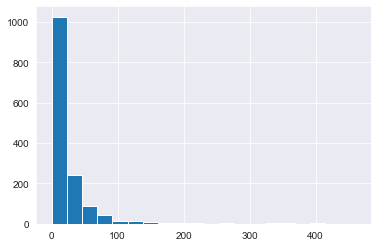

In [43]:
df_train['total_cases'].hist(bins=20)

In [44]:
df_train.iloc[:,4:12].describe()

,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k
count,1262.000000,1404.000000,1434.000000,1434.000000,1443.000000,1446.000000,1446.000000,1446.000000
mean,0.142294,0.130553,0.203783,0.202305,45.760388,298.701852,299.225578,295.246356
std,0.140531,0.119999,0.073860,0.083903,43.715537,1.362420,1.261715,1.527810
min,-0.406250,-0.456100,-0.015533,-0.063457,0.000000,294.635714,294.892857,289.642857
25%,0.044950,0.049217,0.155087,0.144209,9.800000,297.658929,298.257143,294.118929
50%,0.128817,0.121429,0.196050,0.189450,38.340000,298.646429,299.289286,295.640714
75%,0.248483,0.216600,0.248846,0.246982,70.235000,299.833571,300.207143,296.460000
max,0.508357,0.454429,0.538314,0.546017,390.600000,302.200000,302.928571,298.450000


In [45]:
df_train.iloc[:,12:18].describe()

,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg
count,1446.000000,1446.000000,1446.000000,1446.000000,1443.000000,1446.000000
mean,303.427109,295.719156,40.151819,82.161959,45.760388,16.746427
std,3.234601,2.565364,43.434399,7.153897,43.715537,1.542494
min,297.800000,286.900000,0.000000,57.787143,0.000000,11.715714
25%,301.000000,293.900000,13.055000,77.177143,9.800000,15.557143
50%,302.400000,296.200000,27.245000,80.301429,38.340000,17.087143
75%,305.500000,297.900000,52.200000,86.357857,70.235000,17.978214
max,314.000000,299.900000,570.500000,98.610000,390.600000,20.461429


In [46]:
df_train.iloc[:,18:24].describe()

,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
count,1446.000000,1413.000000,1413.000000,1436.000000,1442.000000,1434.000000
mean,4.903754,27.185783,8.059328,32.452437,22.102150,39.326360
std,3.546445,1.292347,2.128568,1.959318,1.574066,47.455314
min,1.357143,21.400000,4.528571,26.700000,14.700000,0.000000
25%,2.328571,26.300000,6.514286,31.100000,21.100000,8.700000
50%,2.857143,27.414286,7.300000,32.800000,22.200000,23.850000
75%,7.625000,28.157143,9.566667,33.900000,23.300000,53.900000
max,16.028571,30.800000,15.800000,42.200000,25.600000,543.300000


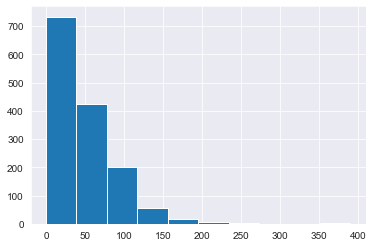

In [47]:
df_train.precipitation_amt_mm.hist()

In [48]:
df_train.isnull().sum()

week_start_date                            0
city                                       0
year                                       0
weekofyear                                 0
ndvi_ne                                  194
ndvi_nw                                   52
ndvi_se                                   22
ndvi_sw                                   22
precipitation_amt_mm                      13
reanalysis_air_temp_k                     10
reanalysis_avg_temp_k                     10
reanalysis_dew_point_temp_k               10
reanalysis_max_air_temp_k                 10
reanalysis_min_air_temp_k                 10
reanalysis_precip_amt_kg_per_m2           10
reanalysis_relative_humidity_percent      10
reanalysis_sat_precip_amt_mm              13
reanalysis_specific_humidity_g_per_kg     10
reanalysis_tdtr_k                         10
station_avg_temp_c                        43
station_diur_temp_rng_c                   43
station_max_temp_c                        20
station_mi

In [49]:
# function to fill all missing values with the mean for each factor

def fill_mean(dataframe):
    for i, col in enumerate(dataframe):
        if col != 'date':
            dataframe[col].fillna(dataframe[col].mean(), inplace=True)
    

In [50]:
train_labels.head()

,city,year,weekofyear,total_cases
0,sj,1990,18,4
1,sj,1990,19,5
2,sj,1990,20,4
3,sj,1990,21,3
4,sj,1990,22,6


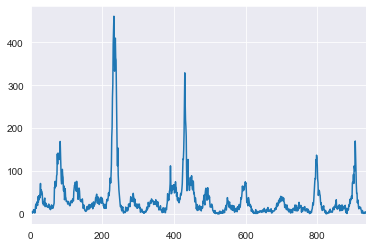

In [51]:
# now look at the driven data dataset
sj_cases = train_labels[train_labels['city'] == 'sj']
iq_cases = train_labels[train_labels['city'] == 'iq']



sj_cases['total_cases'].plot()
# iq_cases['total_cases'].plot()


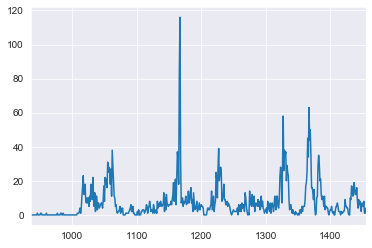

In [52]:
iq_cases['total_cases'].plot()

In [53]:
df_sj.groupby(by = 'year').head(20)

,week_start_date,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,1990-04-30,sj,1990,18,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,1990-05-07,sj,1990,19,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,1990-05-14,sj,1990,20,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,1990-05-21,sj,1990,21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,1990-05-28,sj,1990,22,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
931,2008-03-25,sj,2008,13,0.077850,-0.039900,0.310471,0.296243,27.19,296.958571,...,7.55,74.247143,27.19,13.644286,2.885714,25.042857,5.785714,30.0,21.1,1.8
932,2008-04-01,sj,2008,14,-0.038000,-0.016833,0.119371,0.066386,3.82,298.081429,...,3.67,74.600000,3.82,14.662857,2.714286,26.242857,6.814286,30.6,22.2,0.5
933,2008-04-08,sj,2008,15,-0.155200,-0.052750,0.137757,0.141214,16.96,297.460000,...,35.00,75.027143,16.96,14.184286,2.185714,25.000000,5.714286,29.4,21.7,30.7
934,2008-04-15,sj,2008,16,0.001800,NaN,0.203900,0.209843,0.00,297.630000,...,4.82,72.285714,0.00,13.858571,2.785714,25.314286,6.242857,29.4,21.7,11.2


In [54]:
df_iq.groupby(by = 'year').head(20)

,week_start_date,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
936,2000-07-01,iq,2000,26,0.192886,0.132257,0.340886,0.247200,25.41,296.740000,...,43.19,92.418571,25.41,16.651429,8.928571,26.400000,10.775000,32.5,20.7,3.0
937,2000-07-08,iq,2000,27,0.216833,0.276100,0.289457,0.241657,60.61,296.634286,...,46.00,93.581429,60.61,16.862857,10.314286,26.900000,11.566667,34.0,20.8,55.6
938,2000-07-15,iq,2000,28,0.176757,0.173129,0.204114,0.128014,55.52,296.415714,...,64.77,95.848571,55.52,17.120000,7.385714,26.800000,11.466667,33.0,20.7,38.1
939,2000-07-22,iq,2000,29,0.227729,0.145429,0.254200,0.200314,5.60,295.357143,...,23.96,87.234286,5.60,14.431429,9.114286,25.766667,10.533333,31.5,14.7,30.0
940,2000-07-29,iq,2000,30,0.328643,0.322129,0.254371,0.361043,62.76,296.432857,...,31.80,88.161429,62.76,15.444286,9.500000,26.600000,11.480000,33.3,19.1,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1445,2010-04-16,iq,2010,15,0.157686,0.156614,0.184014,0.135886,17.33,298.305714,...,150.80,93.655714,17.33,18.677143,7.228571,27.150000,9.600000,33.0,21.2,18.0
1446,2010-04-23,iq,2010,16,0.231486,0.294686,0.331657,0.244400,86.70,298.438571,...,81.40,95.995714,86.70,19.448571,7.757143,27.850000,9.600000,33.5,22.5,51.1
1447,2010-04-30,iq,2010,17,0.239743,0.259271,0.307786,0.307943,26.00,299.048571,...,23.60,87.657143,26.00,18.068571,8.257143,28.850000,12.125000,36.2,21.4,35.4
1448,2010-05-07,iq,2010,18,0.260814,0.255786,0.257771,0.340286,73.97,297.617143,...,85.46,96.712857,73.97,18.602857,5.714286,27.600000,9.600000,33.2,21.4,8.1


In [55]:
# check for missing values in driven data data
df_sj.isnull().sum()

week_start_date                            0
city                                       0
year                                       0
weekofyear                                 0
ndvi_ne                                  191
ndvi_nw                                   49
ndvi_se                                   19
ndvi_sw                                   19
precipitation_amt_mm                       9
reanalysis_air_temp_k                      6
reanalysis_avg_temp_k                      6
reanalysis_dew_point_temp_k                6
reanalysis_max_air_temp_k                  6
reanalysis_min_air_temp_k                  6
reanalysis_precip_amt_kg_per_m2            6
reanalysis_relative_humidity_percent       6
reanalysis_sat_precip_amt_mm               9
reanalysis_specific_humidity_g_per_kg      6
reanalysis_tdtr_k                          6
station_avg_temp_c                         6
station_diur_temp_rng_c                    6
station_max_temp_c                         6
station_mi

In [56]:
df_sj.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 936 entries, 0 to 935
Data columns (total 24 columns):
week_start_date                          936 non-null datetime64[ns]
city                                     936 non-null object
year                                     936 non-null int64
weekofyear                               936 non-null int64
ndvi_ne                                  745 non-null float64
ndvi_nw                                  887 non-null float64
ndvi_se                                  917 non-null float64
ndvi_sw                                  917 non-null float64
precipitation_amt_mm                     927 non-null float64
reanalysis_air_temp_k                    930 non-null float64
reanalysis_avg_temp_k                    930 non-null float64
reanalysis_dew_point_temp_k              930 non-null float64
reanalysis_max_air_temp_k                930 non-null float64
reanalysis_min_air_temp_k                930 non-null float64
reanalysis_precip_amt_kg_

In [57]:
df_iq.isnull().sum()

week_start_date                           0
city                                      0
year                                      0
weekofyear                                0
ndvi_ne                                   3
ndvi_nw                                   3
ndvi_se                                   3
ndvi_sw                                   3
precipitation_amt_mm                      4
reanalysis_air_temp_k                     4
reanalysis_avg_temp_k                     4
reanalysis_dew_point_temp_k               4
reanalysis_max_air_temp_k                 4
reanalysis_min_air_temp_k                 4
reanalysis_precip_amt_kg_per_m2           4
reanalysis_relative_humidity_percent      4
reanalysis_sat_precip_amt_mm              4
reanalysis_specific_humidity_g_per_kg     4
reanalysis_tdtr_k                         4
station_avg_temp_c                       37
station_diur_temp_rng_c                  37
station_max_temp_c                       14
station_min_temp_c              

In [58]:
df_iq.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 520 entries, 936 to 1455
Data columns (total 24 columns):
week_start_date                          520 non-null datetime64[ns]
city                                     520 non-null object
year                                     520 non-null int64
weekofyear                               520 non-null int64
ndvi_ne                                  517 non-null float64
ndvi_nw                                  517 non-null float64
ndvi_se                                  517 non-null float64
ndvi_sw                                  517 non-null float64
precipitation_amt_mm                     516 non-null float64
reanalysis_air_temp_k                    516 non-null float64
reanalysis_avg_temp_k                    516 non-null float64
reanalysis_dew_point_temp_k              516 non-null float64
reanalysis_max_air_temp_k                516 non-null float64
reanalysis_min_air_temp_k                516 non-null float64
reanalysis_precip_amt_

In [59]:
# reindex df_iq
df_iq = df_iq.reset_index(drop=True)

In [60]:
df_iq.head()


,week_start_date,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,2000-07-01,iq,2000,26,0.192886,0.132257,0.340886,0.247200,25.41,296.740000,...,43.19,92.418571,25.41,16.651429,8.928571,26.400000,10.775000,32.5,20.7,3.0
1,2000-07-08,iq,2000,27,0.216833,0.276100,0.289457,0.241657,60.61,296.634286,...,46.00,93.581429,60.61,16.862857,10.314286,26.900000,11.566667,34.0,20.8,55.6
2,2000-07-15,iq,2000,28,0.176757,0.173129,0.204114,0.128014,55.52,296.415714,...,64.77,95.848571,55.52,17.120000,7.385714,26.800000,11.466667,33.0,20.7,38.1
3,2000-07-22,iq,2000,29,0.227729,0.145429,0.254200,0.200314,5.60,295.357143,...,23.96,87.234286,5.60,14.431429,9.114286,25.766667,10.533333,31.5,14.7,30.0
4,2000-07-29,iq,2000,30,0.328643,0.322129,0.254371,0.361043,62.76,296.432857,...,31.80,88.161429,62.76,15.444286,9.500000,26.600000,11.480000,33.3,19.1,4.0


In [61]:
df_sj['ndvi_ne'].describe()

count    745.000000
mean       0.057925
std        0.107153
min       -0.406250
25%        0.004500
50%        0.057700
75%        0.111100
max        0.493400
Name: ndvi_ne, dtype: float64

In [62]:
df_sj.drop('city', axis=1, inplace=True)

In [63]:
df_iq.drop('city', axis=1, inplace=True)

In [64]:
# based on this, I'm deciding to fill with the mean again
def fill_mean_2(dataframe):
    for i, col in enumerate(dataframe):
#         print(col)
        if col != 'week_start_date':
            dataframe[col].fillna(dataframe[col].mean(), inplace=True)

In [65]:
fill_mean_2(df_sj)

In [66]:
fill_mean_2(df_iq)

In [67]:
df_sj.isnull().sum()

week_start_date                          0
year                                     0
weekofyear                               0
ndvi_ne                                  0
ndvi_nw                                  0
ndvi_se                                  0
ndvi_sw                                  0
precipitation_amt_mm                     0
reanalysis_air_temp_k                    0
reanalysis_avg_temp_k                    0
reanalysis_dew_point_temp_k              0
reanalysis_max_air_temp_k                0
reanalysis_min_air_temp_k                0
reanalysis_precip_amt_kg_per_m2          0
reanalysis_relative_humidity_percent     0
reanalysis_sat_precip_amt_mm             0
reanalysis_specific_humidity_g_per_kg    0
reanalysis_tdtr_k                        0
station_avg_temp_c                       0
station_diur_temp_rng_c                  0
station_max_temp_c                       0
station_min_temp_c                       0
station_precip_mm                        0
dtype: int6

In [68]:
df_iq.isnull().sum()

week_start_date                          0
year                                     0
weekofyear                               0
ndvi_ne                                  0
ndvi_nw                                  0
ndvi_se                                  0
ndvi_sw                                  0
precipitation_amt_mm                     0
reanalysis_air_temp_k                    0
reanalysis_avg_temp_k                    0
reanalysis_dew_point_temp_k              0
reanalysis_max_air_temp_k                0
reanalysis_min_air_temp_k                0
reanalysis_precip_amt_kg_per_m2          0
reanalysis_relative_humidity_percent     0
reanalysis_sat_precip_amt_mm             0
reanalysis_specific_humidity_g_per_kg    0
reanalysis_tdtr_k                        0
station_avg_temp_c                       0
station_diur_temp_rng_c                  0
station_max_temp_c                       0
station_min_temp_c                       0
station_precip_mm                        0
dtype: int6

# The training datasets are:
* df_sj = 936 records
* df_iq = 520 records


# The labels datasets are:
* sj_train_labels - 936 records
* iq_train_labels - 520 records

labels dataframes have these columns: 'year', 'weekofyear', 'total_cases'

All datasets have the same timedate index

In [69]:
df_sj.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 936 entries, 0 to 935
Data columns (total 23 columns):
week_start_date                          936 non-null datetime64[ns]
year                                     936 non-null int64
weekofyear                               936 non-null int64
ndvi_ne                                  936 non-null float64
ndvi_nw                                  936 non-null float64
ndvi_se                                  936 non-null float64
ndvi_sw                                  936 non-null float64
precipitation_amt_mm                     936 non-null float64
reanalysis_air_temp_k                    936 non-null float64
reanalysis_avg_temp_k                    936 non-null float64
reanalysis_dew_point_temp_k              936 non-null float64
reanalysis_max_air_temp_k                936 non-null float64
reanalysis_min_air_temp_k                936 non-null float64
reanalysis_precip_amt_kg_per_m2          936 non-null float64
reanalysis_relative_humi

In [70]:
df_iq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 23 columns):
week_start_date                          520 non-null datetime64[ns]
year                                     520 non-null int64
weekofyear                               520 non-null int64
ndvi_ne                                  520 non-null float64
ndvi_nw                                  520 non-null float64
ndvi_se                                  520 non-null float64
ndvi_sw                                  520 non-null float64
precipitation_amt_mm                     520 non-null float64
reanalysis_air_temp_k                    520 non-null float64
reanalysis_avg_temp_k                    520 non-null float64
reanalysis_dew_point_temp_k              520 non-null float64
reanalysis_max_air_temp_k                520 non-null float64
reanalysis_min_air_temp_k                520 non-null float64
reanalysis_precip_amt_kg_per_m2          520 non-null float64
reanalysis_relative_humi

In [71]:
sj_train_labels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 936 entries, 0 to 935
Data columns (total 3 columns):
year           936 non-null int64
weekofyear     936 non-null int64
total_cases    936 non-null int64
dtypes: int64(3)
memory usage: 29.2 KB


In [72]:
iq_train_labels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 520 entries, 936 to 1455
Data columns (total 3 columns):
year           520 non-null int64
weekofyear     520 non-null int64
total_cases    520 non-null int64
dtypes: int64(3)
memory usage: 16.2 KB


In [73]:
sj_final = df_sj.copy()
sj_final['total_cases'] = sj_train_labels['total_cases']

In [74]:
sj_final.head()

,week_start_date,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,1990-04-30,1990,18,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,1990-05-07,1990,19,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,1990-05-14,1990,20,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,1990-05-21,1990,21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,1990-05-28,1990,22,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


In [75]:
iq_train_labels = iq_train_labels.reset_index(drop=True)

In [76]:
iq_final = df_iq.copy()
iq_final['total_cases'] = iq_train_labels['total_cases']

In [77]:
iq_final.head()

,week_start_date,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,2000-07-01,2000,26,0.192886,0.132257,0.340886,0.247200,25.41,296.740000,298.450000,...,92.418571,25.41,16.651429,8.928571,26.400000,10.775000,32.5,20.7,3.0,0
1,2000-07-08,2000,27,0.216833,0.276100,0.289457,0.241657,60.61,296.634286,298.428571,...,93.581429,60.61,16.862857,10.314286,26.900000,11.566667,34.0,20.8,55.6,0
2,2000-07-15,2000,28,0.176757,0.173129,0.204114,0.128014,55.52,296.415714,297.392857,...,95.848571,55.52,17.120000,7.385714,26.800000,11.466667,33.0,20.7,38.1,0
3,2000-07-22,2000,29,0.227729,0.145429,0.254200,0.200314,5.60,295.357143,296.228571,...,87.234286,5.60,14.431429,9.114286,25.766667,10.533333,31.5,14.7,30.0,0
4,2000-07-29,2000,30,0.328643,0.322129,0.254371,0.361043,62.76,296.432857,297.635714,...,88.161429,62.76,15.444286,9.500000,26.600000,11.480000,33.3,19.1,4.0,0


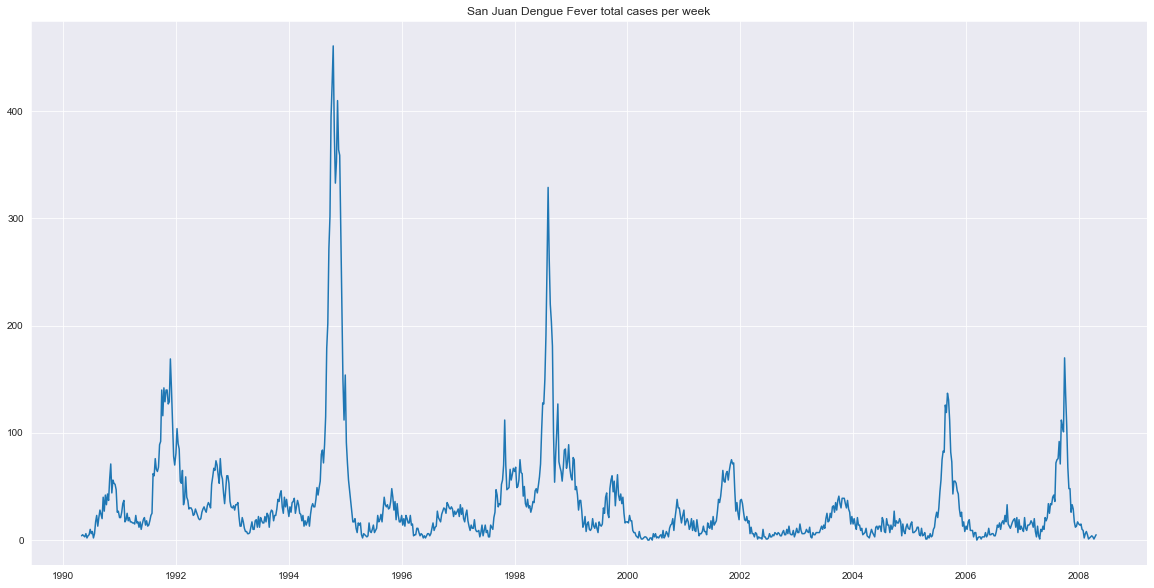

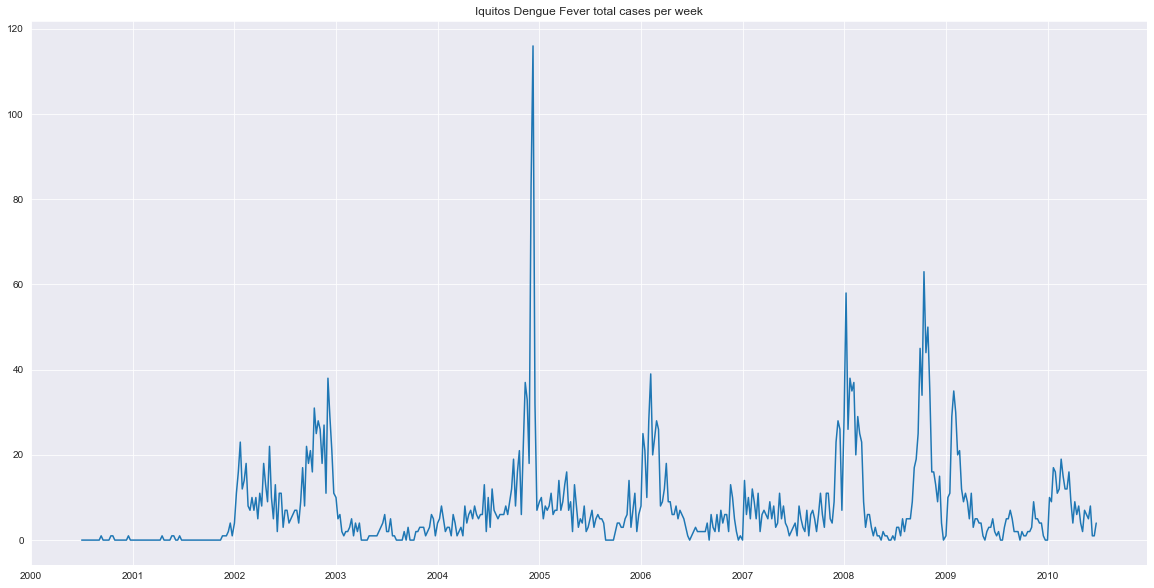

In [78]:
# look at the history of cases in San Juan again
x = sj_final['week_start_date']
y = sj_final['total_cases']
plt.figure(figsize=(20,10))
plt.plot(x,y)
plt.title('San Juan Dengue Fever total cases per week')
plt.show()

# look at the history of cases in San Juan again
x = iq_final['week_start_date']
y = iq_final['total_cases']
plt.figure(figsize=(20,10))
plt.plot(x,y)
plt.title('Iquitos Dengue Fever total cases per week')
plt.show()



# model training and predictions with only the drivendata data

In [79]:
sj_final.drop(['year', 'weekofyear'], axis=1, inplace=True)

In [80]:
iq_final.drop(['year', 'weekofyear'], axis=1, inplace=True)

In [81]:
sj_final.head()

,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


In [82]:
sj_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 936 entries, 0 to 935
Data columns (total 22 columns):
week_start_date                          936 non-null datetime64[ns]
ndvi_ne                                  936 non-null float64
ndvi_nw                                  936 non-null float64
ndvi_se                                  936 non-null float64
ndvi_sw                                  936 non-null float64
precipitation_amt_mm                     936 non-null float64
reanalysis_air_temp_k                    936 non-null float64
reanalysis_avg_temp_k                    936 non-null float64
reanalysis_dew_point_temp_k              936 non-null float64
reanalysis_max_air_temp_k                936 non-null float64
reanalysis_min_air_temp_k                936 non-null float64
reanalysis_precip_amt_kg_per_m2          936 non-null float64
reanalysis_relative_humidity_percent     936 non-null float64
reanalysis_sat_precip_amt_mm             936 non-null float64
reanalysis_specific_

In [83]:
sj_final.columns

Index(['week_start_date', 'ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw',
       'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm', 'total_cases'],
      dtype='object')

# format data for LSTM and try models on San Juan data

In [84]:
# modified from https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 


In [85]:
# 4 weeks chosen based on the life cycle of mosquitos

# use San Juan dataset, 4 week lookback, 1 week predict
# dataset = read_csv('pollution.csv', header=0, index_col=0)
dataset = sj_final.copy()
# df[df.columns[2:4]]
values = dataset[dataset.columns[1:23]].values

# integer encode direction
# encoder = LabelEncoder()
# values[:,4] = encoder.fit_transform(values[:,4])

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, 4, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[0]], axis=1, inplace=True)
print(reframed.head())

   var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var6(t-4)  var7(t-4)  \
4   0.626763   0.523701   0.541889   0.031797   0.261009   0.269188   
5   0.669811   0.435300   0.492142   0.058423   0.362995   0.384892   
6   0.704284   0.422680   0.526662   0.088428   0.454029   0.456909   
7   0.785005   0.594845   0.672866   0.039324   0.486881   0.514759   
8   0.804187   0.652699   0.698613   0.019252   0.571758   0.586777   

   var8(t-4)  var9(t-4)  var10(t-4)  var11(t-4)  ...  var12(t)  var13(t)  \
4   0.339931   0.307693    0.452057    0.056091  ...  0.658555  0.019252   
5   0.528473   0.476925    0.520550    0.031446  ...  0.631272  0.024526   
6   0.710358   0.415386    0.643837    0.045749  ...  0.732451  0.008909   
7   0.695110   0.553848    0.602741    0.024365  ...  0.798465  0.386892   
8   0.757843   0.630772    0.671234    0.021385  ...  0.769331  0.049462   

   var14(t)  var15(t)  var16(t)  var17(t)  var18(t)  var19(t)  var20(t)  \
4  0.711300  0.539535  0.843874  0.899204

In [86]:
reframed.shape

(932, 104)

In [87]:
len(values)

936

In [88]:
# split into train and test sets - 70% for training data
values = reframed.values

# n_train_hours = 365 * 24
n_train_weeks = math.floor(len(values) * .7)
# n_test_week = len(values) - n_train_weeks

train = values[:n_train_weeks, :]
test = values[n_train_weeks:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(652, 1, 103) (652,) (280, 1, 103) (280,)


In [89]:
# values


Train on 652 samples, validate on 280 samples
Epoch 1/100
 - 1s - loss: 0.0949 - val_loss: 0.0522
Epoch 2/100
 - 0s - loss: 0.0778 - val_loss: 0.0347
Epoch 3/100
 - 0s - loss: 0.0627 - val_loss: 0.0268
Epoch 4/100
 - 0s - loss: 0.0620 - val_loss: 0.0271
Epoch 5/100
 - 0s - loss: 0.0594 - val_loss: 0.0267
Epoch 6/100
 - 0s - loss: 0.0576 - val_loss: 0.0260
Epoch 7/100
 - 0s - loss: 0.0569 - val_loss: 0.0261
Epoch 8/100
 - 0s - loss: 0.0516 - val_loss: 0.0257
Epoch 9/100
 - 0s - loss: 0.0500 - val_loss: 0.0251
Epoch 10/100
 - 0s - loss: 0.0461 - val_loss: 0.0250
Epoch 11/100
 - 0s - loss: 0.0442 - val_loss: 0.0278
Epoch 12/100
 - 0s - loss: 0.0434 - val_loss: 0.0306
Epoch 13/100
 - 0s - loss: 0.0418 - val_loss: 0.0263
Epoch 14/100
 - 0s - loss: 0.0380 - val_loss: 0.0227
Epoch 15/100
 - 0s - loss: 0.0406 - val_loss: 0.0228
Epoch 16/100
 - 0s - loss: 0.0359 - val_loss: 0.0245
Epoch 17/100
 - 0s - loss: 0.0388 - val_loss: 0.0204
Epoch 18/100
 - 0s - loss: 0.0352 - val_loss: 0.0223
Epoch 19

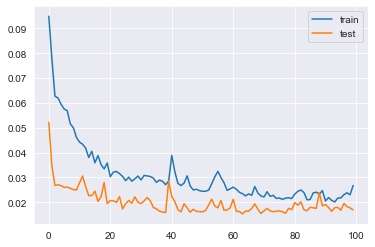

In [90]:
# LSTM model with a dropout layer (30%) as the second layer, 100 epochs

model = Sequential()
model.add(LSTM(103, input_shape=(train_X.shape[1], train_X.shape[2])))

# dropout layer
model.add(Dropout(0.3))

model.add(Dense(50, activation='relu'))

# output layer
model.add(Dense(1))


model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Train on 652 samples, validate on 280 samples
Epoch 1/100
 - 1s - loss: 0.0769 - val_loss: 0.0348
Epoch 2/100
 - 0s - loss: 0.0649 - val_loss: 0.0469
Epoch 3/100
 - 0s - loss: 0.0713 - val_loss: 0.0705
Epoch 4/100
 - 0s - loss: 0.0850 - val_loss: 0.0310
Epoch 5/100
 - 0s - loss: 0.0773 - val_loss: 0.0552
Epoch 6/100
 - 0s - loss: 0.0586 - val_loss: 0.0382
Epoch 7/100
 - 0s - loss: 0.0498 - val_loss: 0.0324
Epoch 8/100
 - 0s - loss: 0.0461 - val_loss: 0.0301
Epoch 9/100
 - 0s - loss: 0.0451 - val_loss: 0.0298
Epoch 10/100
 - 0s - loss: 0.0448 - val_loss: 0.0316
Epoch 11/100
 - 0s - loss: 0.0452 - val_loss: 0.0397
Epoch 12/100
 - 0s - loss: 0.0517 - val_loss: 0.0654
Epoch 13/100
 - 0s - loss: 0.0691 - val_loss: 0.0236
Epoch 14/100
 - 0s - loss: 0.0448 - val_loss: 0.0222
Epoch 15/100
 - 0s - loss: 0.0372 - val_loss: 0.0211
Epoch 16/100
 - 0s - loss: 0.0344 - val_loss: 0.0206
Epoch 17/100
 - 0s - loss: 0.0344 - val_loss: 0.0248
Epoch 18/100
 - 0s - loss: 0.0394 - val_loss: 0.0336
Epoch 19/

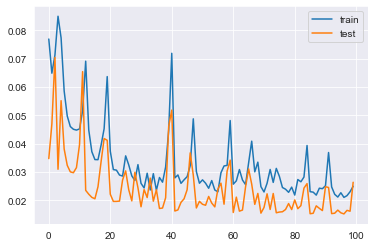

In [91]:
# LSTM model, no dropout layer as the second layer, 100 epochs
model = Sequential()
model.add(LSTM(103, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Train on 652 samples, validate on 280 samples
Epoch 1/100
 - 1s - loss: 0.1509 - val_loss: 0.0321
Epoch 2/100
 - 0s - loss: 0.0867 - val_loss: 0.0435
Epoch 3/100
 - 0s - loss: 0.0717 - val_loss: 0.0324
Epoch 4/100
 - 0s - loss: 0.0692 - val_loss: 0.0294
Epoch 5/100
 - 0s - loss: 0.0665 - val_loss: 0.0294
Epoch 6/100
 - 0s - loss: 0.0644 - val_loss: 0.0292
Epoch 7/100
 - 0s - loss: 0.0625 - val_loss: 0.0289
Epoch 8/100
 - 0s - loss: 0.0602 - val_loss: 0.0287
Epoch 9/100
 - 0s - loss: 0.0587 - val_loss: 0.0285
Epoch 10/100
 - 0s - loss: 0.0588 - val_loss: 0.0284
Epoch 11/100
 - 0s - loss: 0.0579 - val_loss: 0.0281
Epoch 12/100
 - 0s - loss: 0.0574 - val_loss: 0.0281
Epoch 13/100
 - 0s - loss: 0.0552 - val_loss: 0.0279
Epoch 14/100
 - 0s - loss: 0.0543 - val_loss: 0.0297
Epoch 15/100
 - 0s - loss: 0.0530 - val_loss: 0.0275
Epoch 16/100
 - 0s - loss: 0.0520 - val_loss: 0.0271
Epoch 17/100
 - 0s - loss: 0.0500 - val_loss: 0.0267
Epoch 18/100
 - 0s - loss: 0.0484 - val_loss: 0.0246
Epoch 19/

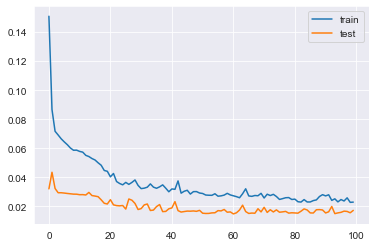

In [92]:
# LSTM model with a dropout layer (50%) as the second layer, 100 epochs

model = Sequential()
model.add(LSTM(103, input_shape=(train_X.shape[1], train_X.shape[2])))

# dropout layer
model.add(Dropout(0.5))

model.add(Dense(50, activation='relu'))

# output layer
model.add(Dense(1))


model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [94]:
# test using 8 week lookback

# use San Juan dataset, 8 week lookback, 1 week predict
# dataset = read_csv('pollution.csv', header=0, index_col=0)
dataset = sj_final.copy()
# df[df.columns[2:4]]
values = dataset[dataset.columns[1:23]].values

# integer encode direction
# encoder = LabelEncoder()
# values[:,4] = encoder.fit_transform(values[:,4])

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, 8, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[0]], axis=1, inplace=True)
print(reframed.head())

    var2(t-8)  var3(t-8)  var4(t-8)  var5(t-8)  var6(t-8)  var7(t-8)  \
8    0.626763   0.523701   0.541889   0.031797   0.261009   0.269188   
9    0.669811   0.435300   0.492142   0.058423   0.362995   0.384892   
10   0.704284   0.422680   0.526662   0.088428   0.454029   0.456909   
11   0.785005   0.594845   0.672866   0.039324   0.486881   0.514759   
12   0.804187   0.652699   0.698613   0.019252   0.571758   0.586777   

    var8(t-8)  var9(t-8)  var10(t-8)  var11(t-8)  ...  var12(t)  var13(t)  \
8    0.339931   0.307693    0.452057    0.056091  ...  0.769331  0.049462   
9    0.528473   0.476925    0.520550    0.031446  ...  0.697971  0.036892   
10   0.710358   0.415386    0.643837    0.045749  ...  0.706882  0.057015   
11   0.695110   0.553848    0.602741    0.024365  ...  0.739375  0.151485   
12   0.757843   0.630772    0.671234    0.021385  ...  0.672128  0.042191   

    var14(t)  var15(t)  var16(t)  var17(t)  var18(t)  var19(t)  var20(t)  \
8   0.786388  0.172093  0.75

In [95]:
# split into train and test sets - 70% for training data
values = reframed.values

# n_train_hours = 365 * 24
n_train_weeks = math.floor(len(values) * .7)
# n_test_week = len(values) - n_train_weeks

train = values[:n_train_weeks, :]
test = values[n_train_weeks:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(649, 1, 187) (649,) (279, 1, 187) (279,)


Train on 649 samples, validate on 279 samples
Epoch 1/100
 - 1s - loss: 0.1024 - val_loss: 0.0306
Epoch 2/100
 - 0s - loss: 0.0765 - val_loss: 0.0369
Epoch 3/100
 - 0s - loss: 0.0616 - val_loss: 0.0294
Epoch 4/100
 - 0s - loss: 0.0676 - val_loss: 0.0427
Epoch 5/100
 - 0s - loss: 0.0579 - val_loss: 0.0279
Epoch 6/100
 - 0s - loss: 0.0564 - val_loss: 0.0287
Epoch 7/100
 - 0s - loss: 0.0607 - val_loss: 0.0318
Epoch 8/100
 - 0s - loss: 0.0596 - val_loss: 0.0320
Epoch 9/100
 - 0s - loss: 0.0558 - val_loss: 0.0287
Epoch 10/100
 - 0s - loss: 0.0493 - val_loss: 0.0285
Epoch 11/100
 - 0s - loss: 0.0474 - val_loss: 0.0268
Epoch 12/100
 - 0s - loss: 0.0461 - val_loss: 0.0273
Epoch 13/100
 - 0s - loss: 0.0547 - val_loss: 0.0241
Epoch 14/100
 - 0s - loss: 0.0469 - val_loss: 0.0358
Epoch 15/100
 - 0s - loss: 0.0481 - val_loss: 0.0269
Epoch 16/100
 - 0s - loss: 0.0520 - val_loss: 0.0291
Epoch 17/100
 - 0s - loss: 0.0406 - val_loss: 0.0243
Epoch 18/100
 - 0s - loss: 0.0416 - val_loss: 0.0276
Epoch 19/

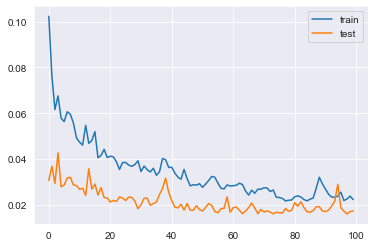

In [96]:
# LSTM model with a dropout layer (30%) as the second layer, 100 epochs

model = Sequential()
model.add(LSTM(103, input_shape=(train_X.shape[1], train_X.shape[2])))

# dropout layer
model.add(Dropout(0.3))

model.add(Dense(50, activation='relu'))

# output layer
model.add(Dense(1))


model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

It looks as though the 4 week lookback works better, let's try a 3, 2, and 1 week lookbacks.

In [97]:
# test using 3 week lookback

# use San Juan dataset, 3 week lookback, 1 week predict
# dataset = read_csv('pollution.csv', header=0, index_col=0)
dataset = sj_final.copy()
# df[df.columns[2:4]]
values = dataset[dataset.columns[1:23]].values

# integer encode direction
# encoder = LabelEncoder()
# values[:,4] = encoder.fit_transform(values[:,4])

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, 3, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[0]], axis=1, inplace=True)
print(reframed.head())

   var2(t-3)  var3(t-3)  var4(t-3)  var5(t-3)  var6(t-3)  var7(t-3)  \
3   0.626763   0.523701   0.541889   0.031797   0.261009   0.269188   
4   0.669811   0.435300   0.492142   0.058423   0.362995   0.384892   
5   0.704284   0.422680   0.526662   0.088428   0.454029   0.456909   
6   0.785005   0.594845   0.672866   0.039324   0.486881   0.514759   
7   0.804187   0.652699   0.698613   0.019252   0.571758   0.586777   

   var8(t-3)  var9(t-3)  var10(t-3)  var11(t-3)  ...  var12(t)  var13(t)  \
3   0.339931   0.307693    0.452057    0.056091  ...  0.652660  0.039324   
4   0.528473   0.476925    0.520550    0.031446  ...  0.658555  0.019252   
5   0.710358   0.415386    0.643837    0.045749  ...  0.631272  0.024526   
6   0.695110   0.553848    0.602741    0.024365  ...  0.732451  0.008909   
7   0.757843   0.630772    0.671234    0.021385  ...  0.798465  0.386892   

   var14(t)  var15(t)  var16(t)  var17(t)  var18(t)  var19(t)  var20(t)  \
3  0.641761  0.348837  0.640316  0.416446

In [98]:
# split into train and test sets - 70% for training data
values = reframed.values

# n_train_hours = 365 * 24
n_train_weeks = math.floor(len(values) * .7)
# n_test_week = len(values) - n_train_weeks

train = values[:n_train_weeks, :]
test = values[n_train_weeks:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(653, 1, 82) (653,) (280, 1, 82) (280,)


Train on 653 samples, validate on 280 samples
Epoch 1/100
 - 1s - loss: 0.0815 - val_loss: 0.0279
Epoch 2/100
 - 0s - loss: 0.0753 - val_loss: 0.0352
Epoch 3/100
 - 0s - loss: 0.0640 - val_loss: 0.0294
Epoch 4/100
 - 0s - loss: 0.0614 - val_loss: 0.0325
Epoch 5/100
 - 0s - loss: 0.0600 - val_loss: 0.0298
Epoch 6/100
 - 0s - loss: 0.0557 - val_loss: 0.0292
Epoch 7/100
 - 0s - loss: 0.0552 - val_loss: 0.0284
Epoch 8/100
 - 0s - loss: 0.0523 - val_loss: 0.0280
Epoch 9/100
 - 0s - loss: 0.0504 - val_loss: 0.0282
Epoch 10/100
 - 0s - loss: 0.0482 - val_loss: 0.0309
Epoch 11/100
 - 0s - loss: 0.0468 - val_loss: 0.0292
Epoch 12/100
 - 0s - loss: 0.0449 - val_loss: 0.0290
Epoch 13/100
 - 0s - loss: 0.0416 - val_loss: 0.0248
Epoch 14/100
 - 0s - loss: 0.0409 - val_loss: 0.0259
Epoch 15/100
 - 0s - loss: 0.0394 - val_loss: 0.0237
Epoch 16/100
 - 0s - loss: 0.0349 - val_loss: 0.0212
Epoch 17/100
 - 0s - loss: 0.0335 - val_loss: 0.0194
Epoch 18/100
 - 0s - loss: 0.0319 - val_loss: 0.0186
Epoch 19/

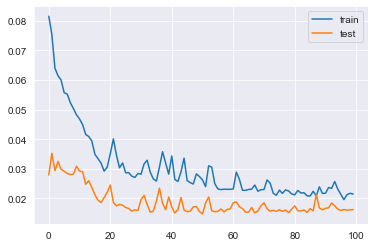

In [99]:
# LSTM model with a dropout layer (30%) as the second layer, 100 epochs

model = Sequential()
model.add(LSTM(103, input_shape=(train_X.shape[1], train_X.shape[2])))

# dropout layer
model.add(Dropout(0.3))

model.add(Dense(50, activation='relu'))

# output layer
model.add(Dense(1))


model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [100]:
# test using 2 week lookback

# use San Juan dataset, 2 week lookback, 1 week predict
# dataset = read_csv('pollution.csv', header=0, index_col=0)
dataset = sj_final.copy()
# df[df.columns[2:4]]
values = dataset[dataset.columns[1:23]].values

# integer encode direction
# encoder = LabelEncoder()
# values[:,4] = encoder.fit_transform(values[:,4])

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, 2, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[0]], axis=1, inplace=True)
print(reframed.head())

   var2(t-2)  var3(t-2)  var4(t-2)  var5(t-2)  var6(t-2)  var7(t-2)  \
2   0.626763   0.523701   0.541889   0.031797   0.261009   0.269188   
3   0.669811   0.435300   0.492142   0.058423   0.362995   0.384892   
4   0.704284   0.422680   0.526662   0.088428   0.454029   0.456909   
5   0.785005   0.594845   0.672866   0.039324   0.486881   0.514759   
6   0.804187   0.652699   0.698613   0.019252   0.571758   0.586777   

   var8(t-2)  var9(t-2)  var10(t-2)  var11(t-2)  ...  var12(t)  var13(t)  \
2   0.339931   0.307693    0.452057    0.056091  ...  0.734987  0.088428   
3   0.528473   0.476925    0.520550    0.031446  ...  0.652660  0.039324   
4   0.710358   0.415386    0.643837    0.045749  ...  0.658555  0.019252   
5   0.695110   0.553848    0.602741    0.024365  ...  0.631272  0.024526   
6   0.757843   0.630772    0.671234    0.021385  ...  0.732451  0.008909   

   var14(t)  var15(t)  var16(t)  var17(t)  var18(t)  var19(t)  var20(t)  \
2  0.664509  0.306977  0.535573  0.363395

In [101]:
# split into train and test sets - 70% for training data
values = reframed.values

# n_train_hours = 365 * 24
n_train_weeks = math.floor(len(values) * .7)
# n_test_week = len(values) - n_train_weeks

train = values[:n_train_weeks, :]
test = values[n_train_weeks:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(653, 1, 61) (653,) (281, 1, 61) (281,)


Train on 653 samples, validate on 281 samples
Epoch 1/100
 - 1s - loss: 0.0763 - val_loss: 0.0363
Epoch 2/100
 - 0s - loss: 0.0721 - val_loss: 0.0306
Epoch 3/100
 - 0s - loss: 0.0654 - val_loss: 0.0316
Epoch 4/100
 - 0s - loss: 0.0596 - val_loss: 0.0301
Epoch 5/100
 - 0s - loss: 0.0609 - val_loss: 0.0303
Epoch 6/100
 - 0s - loss: 0.0564 - val_loss: 0.0292
Epoch 7/100
 - 0s - loss: 0.0569 - val_loss: 0.0292
Epoch 8/100
 - 0s - loss: 0.0549 - val_loss: 0.0303
Epoch 9/100
 - 0s - loss: 0.0508 - val_loss: 0.0293
Epoch 10/100
 - 0s - loss: 0.0496 - val_loss: 0.0280
Epoch 11/100
 - 0s - loss: 0.0502 - val_loss: 0.0290
Epoch 12/100
 - 0s - loss: 0.0486 - val_loss: 0.0244
Epoch 13/100
 - 0s - loss: 0.0414 - val_loss: 0.0244
Epoch 14/100
 - 0s - loss: 0.0391 - val_loss: 0.0260
Epoch 15/100
 - 0s - loss: 0.0370 - val_loss: 0.0344
Epoch 16/100
 - 0s - loss: 0.0377 - val_loss: 0.0290
Epoch 17/100
 - 0s - loss: 0.0378 - val_loss: 0.0362
Epoch 18/100
 - 0s - loss: 0.0479 - val_loss: 0.0310
Epoch 19/

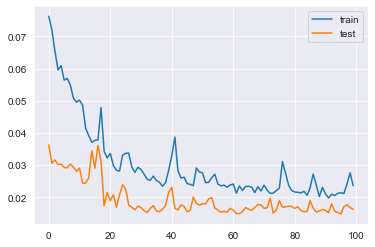

In [102]:
# LSTM model with a dropout layer (30%) as the second layer, 100 epochs

model = Sequential()
model.add(LSTM(103, input_shape=(train_X.shape[1], train_X.shape[2])))

# dropout layer
model.add(Dropout(0.3))

model.add(Dense(50, activation='relu'))

# output layer
model.add(Dense(1))


model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [103]:
# test using 1 week lookback

# use San Juan dataset, 1 week lookback, 1 week predict
# dataset = read_csv('pollution.csv', header=0, index_col=0)
dataset = sj_final.copy()
# df[df.columns[2:4]]
values = dataset[dataset.columns[1:23]].values

# integer encode direction
# encoder = LabelEncoder()
# values[:,4] = encoder.fit_transform(values[:,4])

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[0]], axis=1, inplace=True)
print(reframed.head())

   var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  var7(t-1)  \
1   0.626763   0.523701   0.541889   0.031797   0.261009   0.269188   
2   0.669811   0.435300   0.492142   0.058423   0.362995   0.384892   
3   0.704284   0.422680   0.526662   0.088428   0.454029   0.456909   
4   0.785005   0.594845   0.672866   0.039324   0.486881   0.514759   
5   0.804187   0.652699   0.698613   0.019252   0.571758   0.586777   

   var8(t-1)  var9(t-1)  var10(t-1)  var11(t-1)  ...  var12(t)  var13(t)  \
1   0.339931   0.307693    0.452057    0.056091  ...  0.510214  0.058423   
2   0.528473   0.476925    0.520550    0.031446  ...  0.734987  0.088428   
3   0.710358   0.415386    0.643837    0.045749  ...  0.652660  0.039324   
4   0.695110   0.553848    0.602741    0.024365  ...  0.658555  0.019252   
5   0.757843   0.630772    0.671234    0.021385  ...  0.631272  0.024526   

   var14(t)  var15(t)  var16(t)  var17(t)  var18(t)  var19(t)  var20(t)  \
1  0.473460  0.330233  0.535573  0.342175

In [104]:
# split into train and test sets - 70% for training data
values = reframed.values

# n_train_hours = 365 * 24
n_train_weeks = math.floor(len(values) * .7)
# n_test_week = len(values) - n_train_weeks

train = values[:n_train_weeks, :]
test = values[n_train_weeks:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(654, 1, 40) (654,) (281, 1, 40) (281,)


Train on 654 samples, validate on 281 samples
Epoch 1/100
 - 1s - loss: 0.0843 - val_loss: 0.0334
Epoch 2/100
 - 0s - loss: 0.0850 - val_loss: 0.0720
Epoch 3/100
 - 0s - loss: 0.0638 - val_loss: 0.0298
Epoch 4/100
 - 0s - loss: 0.0696 - val_loss: 0.0444
Epoch 5/100
 - 0s - loss: 0.0607 - val_loss: 0.0312
Epoch 6/100
 - 0s - loss: 0.0631 - val_loss: 0.0357
Epoch 7/100
 - 0s - loss: 0.0608 - val_loss: 0.0345
Epoch 8/100
 - 0s - loss: 0.0587 - val_loss: 0.0311
Epoch 9/100
 - 0s - loss: 0.0603 - val_loss: 0.0332
Epoch 10/100
 - 0s - loss: 0.0585 - val_loss: 0.0320
Epoch 11/100
 - 0s - loss: 0.0593 - val_loss: 0.0316
Epoch 12/100
 - 0s - loss: 0.0578 - val_loss: 0.0317
Epoch 13/100
 - 0s - loss: 0.0561 - val_loss: 0.0295
Epoch 14/100
 - 0s - loss: 0.0572 - val_loss: 0.0335
Epoch 15/100
 - 0s - loss: 0.0543 - val_loss: 0.0299
Epoch 16/100
 - 0s - loss: 0.0536 - val_loss: 0.0290
Epoch 17/100
 - 0s - loss: 0.0540 - val_loss: 0.0296
Epoch 18/100
 - 0s - loss: 0.0513 - val_loss: 0.0289
Epoch 19/

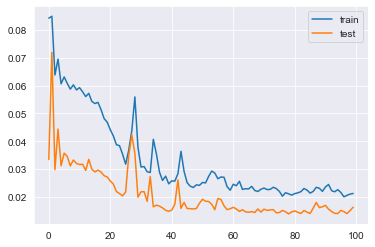

In [105]:
# LSTM model with a dropout layer (30%) as the second layer, 100 epochs

model = Sequential()
model.add(LSTM(103, input_shape=(train_X.shape[1], train_X.shape[2])))

# dropout layer
model.add(Dropout(0.3))

model.add(Dense(50, activation='relu'))

# output layer
model.add(Dense(1))


model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# format data for LSTM and try models on Iquitos data

In [106]:
iq_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 22 columns):
week_start_date                          520 non-null datetime64[ns]
ndvi_ne                                  520 non-null float64
ndvi_nw                                  520 non-null float64
ndvi_se                                  520 non-null float64
ndvi_sw                                  520 non-null float64
precipitation_amt_mm                     520 non-null float64
reanalysis_air_temp_k                    520 non-null float64
reanalysis_avg_temp_k                    520 non-null float64
reanalysis_dew_point_temp_k              520 non-null float64
reanalysis_max_air_temp_k                520 non-null float64
reanalysis_min_air_temp_k                520 non-null float64
reanalysis_precip_amt_kg_per_m2          520 non-null float64
reanalysis_relative_humidity_percent     520 non-null float64
reanalysis_sat_precip_amt_mm             520 non-null float64
reanalysis_specific_

In [107]:
# use Iquitos dataset, 4 week lookback, 1 week predict

# dataset = read_csv('pollution.csv', header=0, index_col=0)
dataset = iq_final.copy()
# df[df.columns[2:4]]
values = dataset[dataset.columns[1:24]].values

# integer encode direction
# encoder = LabelEncoder()
# values[:,4] = encoder.fit_transform(values[:,4])

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, 4, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[0]], axis=1, inplace=True)
print(reframed.head())

   var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var6(t-4)  var7(t-4)  \
4   0.230302   0.611693   0.379834   0.120524   0.300549   0.442669   
5   0.573956   0.510542   0.368330   0.287483   0.285450   0.439999   
6   0.327948   0.342688   0.132475   0.263340   0.254234   0.311111   
7   0.261770   0.441198   0.282527   0.026562   0.103043   0.166222   
8   0.683923   0.441535   0.616104   0.297681   0.256683   0.341331   

   var8(t-4)  var9(t-4)  var10(t-4)  var11(t-4)  ...  var12(t)  var13(t)  \
4   0.609428   0.521429    0.681320    0.119300  ...  0.744051  0.297681   
5   0.630276   0.471430    0.461540    0.127061  ...  0.414999  0.077029   
6   0.661880   0.321430    0.626373    0.178908  ...  0.624370  0.423896   
7   0.323936   0.257145    0.186815    0.066182  ...  0.605123  0.199592   
8   0.462669   0.500000    0.505493    0.087838  ...  0.415279  0.233458   

   var14(t)  var15(t)  var16(t)  var17(t)  var18(t)  var19(t)  var20(t)  \
4  0.399145  0.469838  0.553191  0.592453

In [108]:
# split into train and test sets - 80% for training data
# this smaller dataset worked a little better by using 90% for training

values = reframed.values

# n_train_hours = 365 * 24
n_train_weeks = math.floor(len(values) * .9)
# n_test_week = len(values) - n_train_weeks

train = values[:n_train_weeks, :]
test = values[n_train_weeks:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(464, 1, 103) (464,) (52, 1, 103) (52,)


Train on 464 samples, validate on 52 samples
Epoch 1/250
 - 1s - loss: 0.0852 - val_loss: 0.0343
Epoch 2/250
 - 0s - loss: 0.0696 - val_loss: 0.0406
Epoch 3/250
 - 0s - loss: 0.0675 - val_loss: 0.0389
Epoch 4/250
 - 0s - loss: 0.0593 - val_loss: 0.0330
Epoch 5/250
 - 0s - loss: 0.0599 - val_loss: 0.0326
Epoch 6/250
 - 0s - loss: 0.0573 - val_loss: 0.0332
Epoch 7/250
 - 0s - loss: 0.0531 - val_loss: 0.0363
Epoch 8/250
 - 0s - loss: 0.0556 - val_loss: 0.0325
Epoch 9/250
 - 0s - loss: 0.0520 - val_loss: 0.0325
Epoch 10/250
 - 0s - loss: 0.0534 - val_loss: 0.0308
Epoch 11/250
 - 0s - loss: 0.0516 - val_loss: 0.0319
Epoch 12/250
 - 0s - loss: 0.0506 - val_loss: 0.0333
Epoch 13/250
 - 0s - loss: 0.0497 - val_loss: 0.0305
Epoch 14/250
 - 0s - loss: 0.0490 - val_loss: 0.0300
Epoch 15/250
 - 0s - loss: 0.0502 - val_loss: 0.0293
Epoch 16/250
 - 0s - loss: 0.0487 - val_loss: 0.0289
Epoch 17/250
 - 0s - loss: 0.0481 - val_loss: 0.0296
Epoch 18/250
 - 0s - loss: 0.0472 - val_loss: 0.0279
Epoch 19/2

Epoch 154/250
 - 0s - loss: 0.0300 - val_loss: 0.0218
Epoch 155/250
 - 0s - loss: 0.0325 - val_loss: 0.0228
Epoch 156/250
 - 0s - loss: 0.0301 - val_loss: 0.0221
Epoch 157/250
 - 0s - loss: 0.0307 - val_loss: 0.0222
Epoch 158/250
 - 0s - loss: 0.0306 - val_loss: 0.0222
Epoch 159/250
 - 0s - loss: 0.0302 - val_loss: 0.0217
Epoch 160/250
 - 0s - loss: 0.0304 - val_loss: 0.0252
Epoch 161/250
 - 0s - loss: 0.0303 - val_loss: 0.0243
Epoch 162/250
 - 0s - loss: 0.0324 - val_loss: 0.0231
Epoch 163/250
 - 0s - loss: 0.0299 - val_loss: 0.0236
Epoch 164/250
 - 0s - loss: 0.0288 - val_loss: 0.0216
Epoch 165/250
 - 0s - loss: 0.0305 - val_loss: 0.0225
Epoch 166/250
 - 0s - loss: 0.0302 - val_loss: 0.0223
Epoch 167/250
 - 0s - loss: 0.0289 - val_loss: 0.0223
Epoch 168/250
 - 0s - loss: 0.0299 - val_loss: 0.0221
Epoch 169/250
 - 0s - loss: 0.0301 - val_loss: 0.0202
Epoch 170/250
 - 0s - loss: 0.0300 - val_loss: 0.0220
Epoch 171/250
 - 0s - loss: 0.0291 - val_loss: 0.0230
Epoch 172/250
 - 0s - loss: 

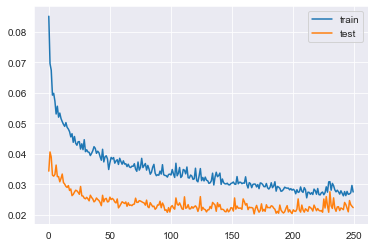

In [109]:
# LSTM model with a dropout layer (30%) as the second layer, 100 epochs
# higher dropout rate improved performance slightly

model = Sequential()
model.add(LSTM(103, input_shape=(train_X.shape[1], train_X.shape[2])))

# dropout layer
model.add(Dropout(0.5))

model.add(Dense(50, activation='relu'))

# output layer
model.add(Dense(1))


model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=250, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [114]:
# use Iquitos dataset, 3 week lookback, 1 week predict

# dataset = read_csv('pollution.csv', header=0, index_col=0)
dataset = iq_final.copy()
# df[df.columns[2:4]]
values = dataset[dataset.columns[1:24]].values

# integer encode direction
# encoder = LabelEncoder()
# values[:,4] = encoder.fit_transform(values[:,4])

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, 3, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[0]], axis=1, inplace=True)
print(reframed.head())

   var2(t-3)  var3(t-3)  var4(t-3)  var5(t-3)  var6(t-3)  var7(t-3)  \
3   0.230302   0.611693   0.379834   0.120524   0.300549   0.442669   
4   0.573956   0.510542   0.368330   0.287483   0.285450   0.439999   
5   0.327948   0.342688   0.132475   0.263340   0.254234   0.311111   
6   0.261770   0.441198   0.282527   0.026562   0.103043   0.166222   
7   0.683923   0.441535   0.616104   0.297681   0.256683   0.341331   

   var8(t-3)  var9(t-3)  var10(t-3)  var11(t-3)  ...  var12(t)  var13(t)  \
3   0.609428   0.521429    0.681320    0.119300  ...  0.721340  0.026562   
4   0.630276   0.471430    0.461540    0.127061  ...  0.744051  0.297681   
5   0.661880   0.321430    0.626373    0.178908  ...  0.414999  0.077029   
6   0.323936   0.257145    0.186815    0.066182  ...  0.624370  0.423896   
7   0.462669   0.500000    0.505493    0.087838  ...  0.605123  0.199592   

   var14(t)  var15(t)  var16(t)  var17(t)  var18(t)  var19(t)  var20(t)  \
3  0.277844  0.438515  0.464539  0.503145

In [115]:
# split into train and test sets - 80% for training data
# this smaller dataset worked a little better by using 90% for training

values = reframed.values

# n_train_hours = 365 * 24
n_train_weeks = math.floor(len(values) * .9)
# n_test_week = len(values) - n_train_weeks

train = values[:n_train_weeks, :]
test = values[n_train_weeks:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(465, 1, 82) (465,) (52, 1, 82) (52,)


Train on 465 samples, validate on 52 samples
Epoch 1/250
 - 1s - loss: 0.1089 - val_loss: 0.0781
Epoch 2/250
 - 0s - loss: 0.0823 - val_loss: 0.0313
Epoch 3/250
 - 0s - loss: 0.0634 - val_loss: 0.0403
Epoch 4/250
 - 0s - loss: 0.0620 - val_loss: 0.0303
Epoch 5/250
 - 0s - loss: 0.0587 - val_loss: 0.0308
Epoch 6/250
 - 0s - loss: 0.0541 - val_loss: 0.0314
Epoch 7/250
 - 0s - loss: 0.0554 - val_loss: 0.0314
Epoch 8/250
 - 0s - loss: 0.0523 - val_loss: 0.0310
Epoch 9/250
 - 0s - loss: 0.0535 - val_loss: 0.0306
Epoch 10/250
 - 0s - loss: 0.0511 - val_loss: 0.0294
Epoch 11/250
 - 0s - loss: 0.0505 - val_loss: 0.0287
Epoch 12/250
 - 0s - loss: 0.0496 - val_loss: 0.0276
Epoch 13/250
 - 0s - loss: 0.0481 - val_loss: 0.0283
Epoch 14/250
 - 0s - loss: 0.0494 - val_loss: 0.0280
Epoch 15/250
 - 0s - loss: 0.0485 - val_loss: 0.0279
Epoch 16/250
 - 0s - loss: 0.0486 - val_loss: 0.0275
Epoch 17/250
 - 0s - loss: 0.0469 - val_loss: 0.0256
Epoch 18/250
 - 0s - loss: 0.0466 - val_loss: 0.0259
Epoch 19/2

Epoch 154/250
 - 0s - loss: 0.0313 - val_loss: 0.0221
Epoch 155/250
 - 0s - loss: 0.0309 - val_loss: 0.0203
Epoch 156/250
 - 0s - loss: 0.0317 - val_loss: 0.0197
Epoch 157/250
 - 0s - loss: 0.0323 - val_loss: 0.0223
Epoch 158/250
 - 0s - loss: 0.0301 - val_loss: 0.0203
Epoch 159/250
 - 0s - loss: 0.0313 - val_loss: 0.0206
Epoch 160/250
 - 0s - loss: 0.0307 - val_loss: 0.0247
Epoch 161/250
 - 0s - loss: 0.0311 - val_loss: 0.0197
Epoch 162/250
 - 0s - loss: 0.0314 - val_loss: 0.0225
Epoch 163/250
 - 0s - loss: 0.0302 - val_loss: 0.0198
Epoch 164/250
 - 0s - loss: 0.0313 - val_loss: 0.0203
Epoch 165/250
 - 0s - loss: 0.0306 - val_loss: 0.0227
Epoch 166/250
 - 0s - loss: 0.0308 - val_loss: 0.0237
Epoch 167/250
 - 0s - loss: 0.0313 - val_loss: 0.0203
Epoch 168/250
 - 0s - loss: 0.0313 - val_loss: 0.0211
Epoch 169/250
 - 0s - loss: 0.0316 - val_loss: 0.0223
Epoch 170/250
 - 0s - loss: 0.0308 - val_loss: 0.0212
Epoch 171/250
 - 0s - loss: 0.0318 - val_loss: 0.0211
Epoch 172/250
 - 0s - loss: 

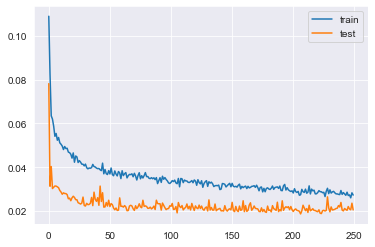

In [116]:
# LSTM model with a dropout layer (30%) as the second layer, 100 epochs
# higher dropout rate improved performance slightly

model = Sequential()
model.add(LSTM(103, input_shape=(train_X.shape[1], train_X.shape[2])))

# dropout layer
model.add(Dropout(0.5))

model.add(Dense(50, activation='relu'))

# output layer
model.add(Dense(1))


model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=250, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

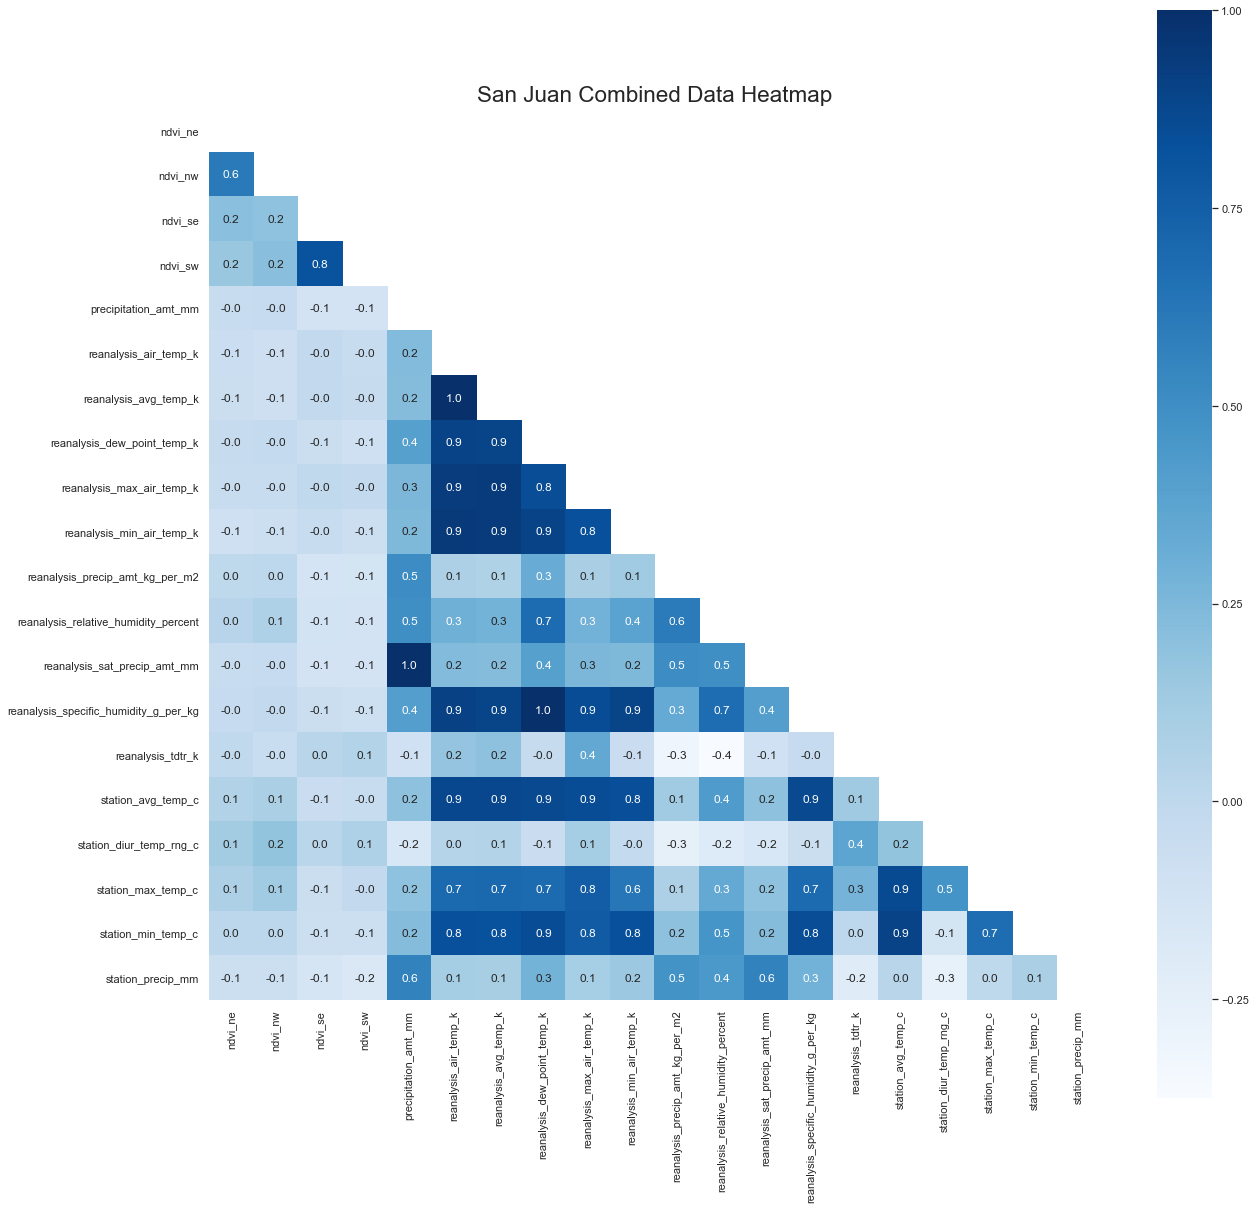

In [117]:
# look at a correlation heat map for San Juan
# some code modified from https://seaborn.pydata.org/examples/many_pairwise_correlations.html
sns.set(style="white") #to make mask show notebook background

df_corr = sj_final.drop('total_cases', axis=1)
corr = df_corr.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f,ax = plt.subplots(figsize=(20,20))

hm = sns.heatmap(corr, mask=mask, annot=True, square=True, cmap="Blues", fmt='.1f', annot_kws={'size': 12} )

sns.set(font_scale=1.3)
hm.set_ylim(20,0)
plt.title('San Juan Combined Data Heatmap', fontsize='x-large')
plt.show()

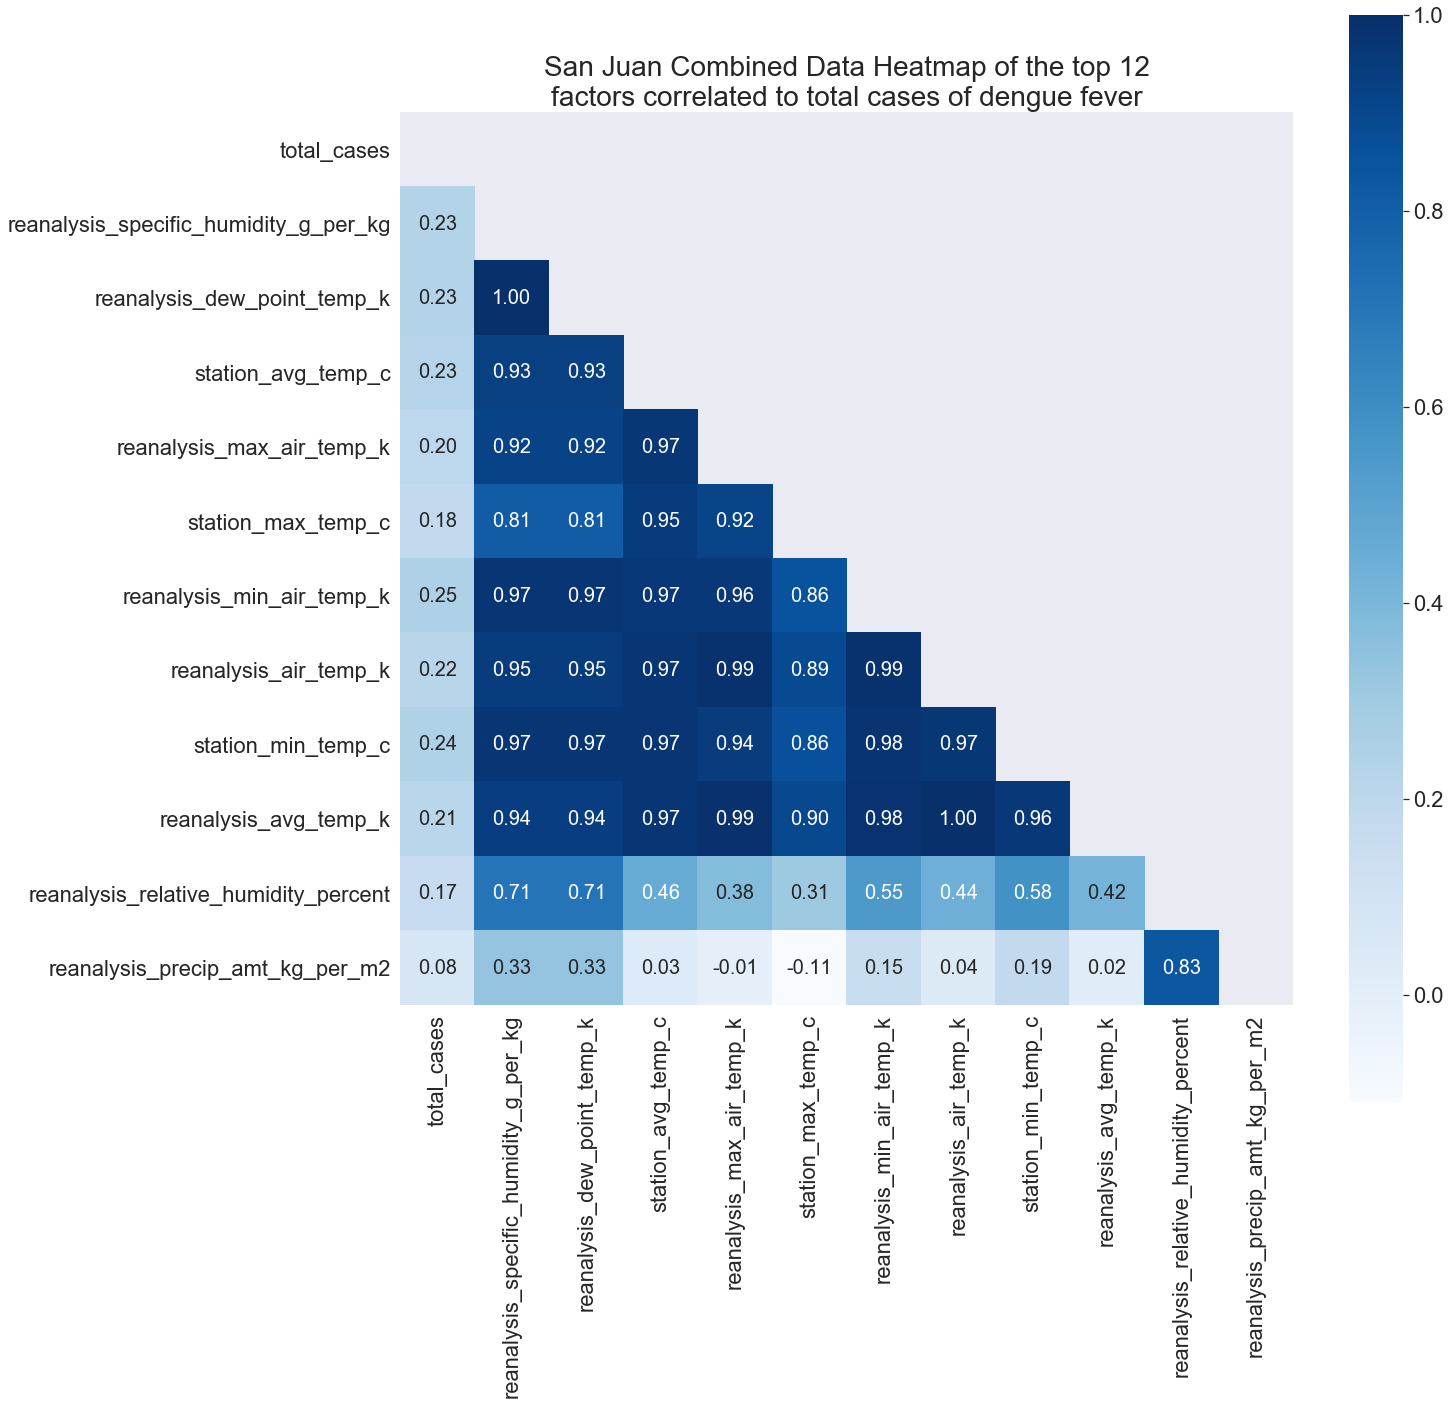

In [118]:
sns.set(style="white")

corr_to_target = sj_final.corr()

k = 12 #number of variables for heatmap

cols = corr_to_target.nlargest(k, 'total_cases')['total_cases'].index

cm = np.corrcoef(corr_to_target[cols].values.T)

mask = np.zeros_like(cm, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig = plt.figure(figsize=(20,20))

sns.set(font_scale=2)
hm = sns.heatmap(cm, cbar=True, annot=True, mask=mask, square=True, cmap="Blues", fmt='.2f', annot_kws={'size': 20},
                 yticklabels = cols.values, xticklabels = cols.values)

hm.set_ylim(12,0)

plt.title('San Juan Combined Data Heatmap of the top {}\nfactors correlated to total cases of dengue fever'.format(k), fontsize=28)
plt.show()

Some tests on using a smaller data history to train and see how it performa

Train on 374 samples, validate on 561 samples
Epoch 1/100
 - 1s - loss: 0.1098 - val_loss: 0.0831
Epoch 2/100
 - 0s - loss: 0.0737 - val_loss: 0.0431
Epoch 3/100
 - 0s - loss: 0.0784 - val_loss: 0.0431
Epoch 4/100
 - 0s - loss: 0.0685 - val_loss: 0.0454
Epoch 5/100
 - 0s - loss: 0.0652 - val_loss: 0.0446
Epoch 6/100
 - 0s - loss: 0.0654 - val_loss: 0.0430
Epoch 7/100
 - 0s - loss: 0.0668 - val_loss: 0.0433
Epoch 8/100
 - 0s - loss: 0.0664 - val_loss: 0.0433
Epoch 9/100
 - 0s - loss: 0.0652 - val_loss: 0.0437
Epoch 10/100
 - 0s - loss: 0.0655 - val_loss: 0.0435
Epoch 11/100
 - 0s - loss: 0.0651 - val_loss: 0.0433
Epoch 12/100
 - 0s - loss: 0.0646 - val_loss: 0.0433
Epoch 13/100
 - 0s - loss: 0.0651 - val_loss: 0.0431
Epoch 14/100
 - 0s - loss: 0.0631 - val_loss: 0.0426
Epoch 15/100
 - 0s - loss: 0.0625 - val_loss: 0.0422
Epoch 16/100
 - 0s - loss: 0.0627 - val_loss: 0.0415
Epoch 17/100
 - 0s - loss: 0.0633 - val_loss: 0.0411
Epoch 18/100
 - 0s - loss: 0.0629 - val_loss: 0.0411
Epoch 19/

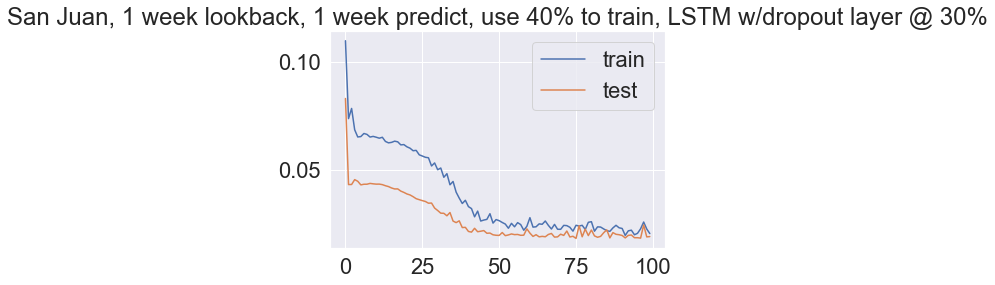

In [119]:
# test using 1 week lookback, only train on 40% of the data

# use San Juan dataset, 1 week lookback, 1 week predict

dataset = sj_final.copy()

values = dataset[dataset.columns[1:23]].values

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[0]], axis=1, inplace=True)
# print(reframed.head())

# split into train and test sets - 40% for training data
values = reframed.values
n_train_weeks = math.floor(len(values) * .4)


train = values[:n_train_weeks, :]
test = values[n_train_weeks:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

# print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# LSTM model with a dropout layer (30%) as the second layer, 100 epochs

model = Sequential()
model.add(LSTM(103, input_shape=(train_X.shape[1], train_X.shape[2])))

# dropout layer
model.add(Dropout(0.3))

model.add(Dense(50, activation='relu'))

# output layer
model.add(Dense(1))


model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.title('San Juan, 1 week lookback, 1 week predict, use 40% to train, LSTM w/dropout layer @ 30%')
plt.show()

Train on 415 samples, validate on 104 samples
Epoch 1/100
 - 1s - loss: 0.0727 - val_loss: 0.0713
Epoch 2/100
 - 0s - loss: 0.0623 - val_loss: 0.0611
Epoch 3/100
 - 0s - loss: 0.0544 - val_loss: 0.0590
Epoch 4/100
 - 0s - loss: 0.0518 - val_loss: 0.0584
Epoch 5/100
 - 0s - loss: 0.0512 - val_loss: 0.0587
Epoch 6/100
 - 0s - loss: 0.0496 - val_loss: 0.0583
Epoch 7/100
 - 0s - loss: 0.0488 - val_loss: 0.0579
Epoch 8/100
 - 0s - loss: 0.0490 - val_loss: 0.0577
Epoch 9/100
 - 0s - loss: 0.0485 - val_loss: 0.0572
Epoch 10/100
 - 0s - loss: 0.0493 - val_loss: 0.0572
Epoch 11/100
 - 0s - loss: 0.0473 - val_loss: 0.0565
Epoch 12/100
 - 0s - loss: 0.0460 - val_loss: 0.0562
Epoch 13/100
 - 0s - loss: 0.0473 - val_loss: 0.0568
Epoch 14/100
 - 0s - loss: 0.0465 - val_loss: 0.0561
Epoch 15/100
 - 0s - loss: 0.0462 - val_loss: 0.0554
Epoch 16/100
 - 0s - loss: 0.0469 - val_loss: 0.0556
Epoch 17/100
 - 0s - loss: 0.0453 - val_loss: 0.0554
Epoch 18/100
 - 0s - loss: 0.0453 - val_loss: 0.0550
Epoch 19/

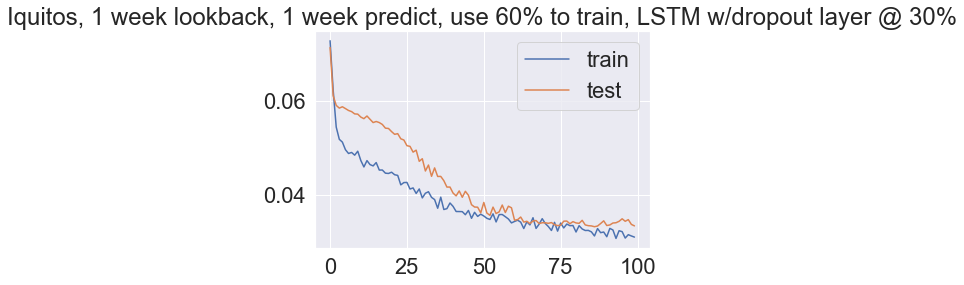

In [124]:
# test using 1 week lookback, only train on 60% of the data

# use Iquitos dataset, 1 week lookback, 1 week predict

dataset = iq_final.copy()

values = dataset[dataset.columns[1:23]].values

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[0]], axis=1, inplace=True)
# print(reframed.head())

# split into train and test sets - 50% for training data
values = reframed.values
n_train_weeks = math.floor(len(values) * .8)


train = values[:n_train_weeks, :]
test = values[n_train_weeks:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

# print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# LSTM model with a dropout layer (30%) as the second layer, 100 epochs

model = Sequential()
model.add(LSTM(103, input_shape=(train_X.shape[1], train_X.shape[2])))

# dropout layer
model.add(Dropout(0.3))

model.add(Dense(50, activation='relu'))

# output layer
model.add(Dense(1))


model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('epoch')
plt.ylabel('')
plt.title('Iquitos, 1 week lookback, 1 week predict, use 60% to train, LSTM w/dropout layer @ 30%')
plt.show()

In [170]:
# function to format the data and run an LSTM model
# this is a line just to reset this cell


def run_lstm(dataset_in, dataset_name_string, chart_title, start_col, end_col, lookback_periods, train_proportion, dropout_proportion, epoch_count):
    
    #get values, start with start_col, which in this application skips 'week_start_date'
    dataset = dataset_in.copy()
    values = 0
    values = dataset[dataset.columns[start_col:end_col]].values
#     values = dataset[dataset.columns[1:23]].values

    # ensure all data are of type float32
    values = values.astype('float32')

    # normalize all features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)

    # convert data to proper format for supervised learning using lookback_periods
    reframed = series_to_supervised(scaled, lookback_periods, 1)
    
    # drop columns we don't want to predict
#     reframed.drop(reframed.columns[[0]], axis=1, inplace=True)   # this is not necessary?

    # split the date into train and test proportions
    values = reframed.values
    n_train_weeks = math.floor(len(values) * train_proportion)
    train = values[:n_train_weeks, :]
    test = values[n_train_weeks:, :]
    
    # split into explanatry (as opposed to independant) and response varibles. Last column is the response variable
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    
    # LSTM model with a dropout layer of specified proportion as the second layer, and epochs specified
    model = Sequential()
    model.add(LSTM(103, input_shape=(train_X.shape[1], train_X.shape[2])))

    # dropout layer
    model.add(Dropout(dropout_proportion))

    model.add(Dense(50, activation='relu'))

    # output layer
    model.add(Dense(1))


    model.compile(loss='mae', optimizer='adam')

    # fit model
    history = model.fit(train_X, train_y, epochs=epoch_count, batch_size=72, validation_data=(test_X, test_y), verbose=0, shuffle=False)
    
    # output
    print('Dataset name: {}'.format(dataset_name_string))
    print('Lookback window: {}'.format(lookback_periods))
    print('Training proportion: {}'.format(train_proportion))
    print('Dropout proportion: {}'.format(dropout_proportion))
    print('last epoch loss: {}'.format(history.history['loss'][-1]))
    print('last epoch val_loss: {}'.format(history.history['val_loss'][-1]))

    # plot history
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.xlabel('epochs')
    plt.ylabel('loss proportion')
    plt.legend()
    plt.title('Location: {}'.format(dataset_name_string))
    plt.show()
        

Dataset name: iq_final
Lookback window: 3
Training proportion: 0.8
Dropout proportion: 0.3
last epoch loss: 0.029905688973734513
last epoch val_loss: 0.039392374169368014


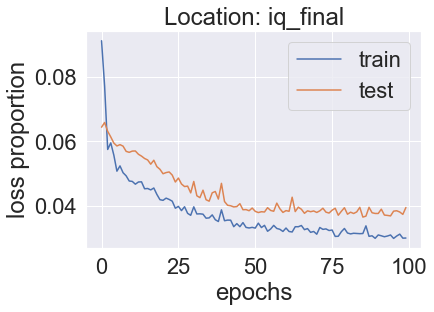

In [171]:
# run_lstm(dataset_in, dataset_name_string, chart_title, start_col, end_col, lookback_periods, train_proportion, 
#          dropout_proportion, epoch_count) 

run_lstm(iq_final, "iq_final", "Iquitos, Peru", 1, 23, 3, .8, .3, 100)

Dataset name: sj_final
Lookback window: 3
Training proportion: 0.8
Dropout proportion: 0.3
last epoch loss: 0.018695804789842133
last epoch val_loss: 0.01961000492786341


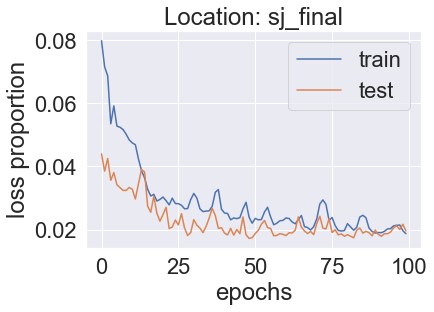

In [173]:
run_lstm(sj_final, 'sj_final', 'San Juan, Puerto Rico', 1, 23, 3, .8, .3, 100)

In [ ]:
# save this example of the json object returned by the darksky api

# {
#     "latitude": 18.4653,
#     "longitude": -66.1167,
#     "timezone": "America/Puerto_Rico",
#     "daily": {
#         "data": [
#             {
#                 "time": 609998400,
#                 "summary": "Drizzle in the morning.",
#                 "icon": "rain",
#                 "sunriseTime": 610019894,
#                 "sunsetTime": 610066033,
#                 "moonPhase": 0.87,
#                 "precipIntensity": 0.001,
#                 "precipIntensityMax": 0.0118,
#                 "precipIntensityMaxTime": 610005600,
#                 "precipProbability": 1,
#                 "precipType": "rain",
#                 "temperatureHigh": 85.9,
#                 "temperatureHighTime": 610048800,
#                 "temperatureLow": 72.95,
#                 "temperatureLowTime": 610095600,
#                 "apparentTemperatureHigh": 88.2,
#                 "apparentTemperatureHighTime": 610048800,
#                 "apparentTemperatureLow": 74.07,
#                 "apparentTemperatureLowTime": 610095600,
#                 "dewPoint": 70.15,
#                 "humidity": 0.77,
#                 "pressure": 1017,
#                 "windSpeed": 10.32,
#                 "windBearing": 110,
#                 "cloudCover": 0.41,
#                 "uvIndex": 6,
#                 "uvIndexTime": 610038000,
#                 "temperatureMin": 72.95,
#                 "temperatureMinTime": 610009200,
#                 "temperatureMax": 85.9,
#                 "temperatureMaxTime": 610048800,
#                 "apparentTemperatureMin": 74.36,
#                 "apparentTemperatureMinTime": 610009200,
#                 "apparentTemperatureMax": 88.2,
#                 "apparentTemperatureMaxTime": 610048800
#             }
#         ]
#     },
#     "offset": -4
# }

In [125]:
iq_final.head()

,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,2000-07-01,0.192886,0.132257,0.340886,0.247200,25.41,296.740000,298.450000,295.184286,307.3,...,92.418571,25.41,16.651429,8.928571,26.400000,10.775000,32.5,20.7,3.0,0
1,2000-07-08,0.216833,0.276100,0.289457,0.241657,60.61,296.634286,298.428571,295.358571,306.6,...,93.581429,60.61,16.862857,10.314286,26.900000,11.566667,34.0,20.8,55.6,0
2,2000-07-15,0.176757,0.173129,0.204114,0.128014,55.52,296.415714,297.392857,295.622857,304.5,...,95.848571,55.52,17.120000,7.385714,26.800000,11.466667,33.0,20.7,38.1,0
3,2000-07-22,0.227729,0.145429,0.254200,0.200314,5.60,295.357143,296.228571,292.797143,303.6,...,87.234286,5.60,14.431429,9.114286,25.766667,10.533333,31.5,14.7,30.0,0
4,2000-07-29,0.328643,0.322129,0.254371,0.361043,62.76,296.432857,297.635714,293.957143,307.0,...,88.161429,62.76,15.444286,9.500000,26.600000,11.480000,33.3,19.1,4.0,0
